In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from bs4 import BeautifulSoup
import requests
import time
from tqdm import tqdm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных из Spark

In [2]:
spark_data = pd.read_csv('spark_data.csv', index_col=0)

spark_data

Объект_1         ИНН_1    Связь  \
0                     РОСИМУЩЕСТВО    7710723134  Высокая   
1                     РОСИМУЩЕСТВО    7710723134  Высокая   
2                     РОСИМУЩЕСТВО    7710723134  Высокая   
3                     РОСИМУЩЕСТВО    7710723134  Высокая   
4                     РОСИМУЩЕСТВО    7710723134  Высокая   
...                            ...           ...      ...   
2413                ПАО "РУСОЛОВО"    7706774915  Высокая   
2414  Аветисян Владимир Евгеньевич  631900874344  Высокая   
2415                ООО "ГАЛИЧЛЕС"    4433000086  Высокая   
2416      Матвиенко Антон Павлович  780520034503  Высокая   
2417                 ООО "КАРГИЛЛ"    7113502396  Высокая   

                               Объект_2       ИНН_2  
0                          ООО "ВАГРАН"  7707113058  
1                       ООО "ТЕХСЕРВИС"  2338012377  
2              ООО "ТАУРОВСКИЙ УЧАСТОК"  7719473305  
3     ООО "АГРОКОМПЛЕКС "КАМЫШЕВАТСКИЙ"  2361010508  
4        ООО "ЕДИНЫЙ МЕДИЦИНСКИЙ ЦЕНТР"  7842416531  
...                                 ...         ...  
2413                          ООО "НРА"  7714911548  
2414                       АО "АВТОВАЗ"  6320002223  
2415                    АО "АЛЬФА-БАНК"  7728168971  
2416         ООО "КОНЦЕПЦИЯ УПРАВЛЕНИЯ"  7727839000  
2417                           АО "КСК"  2315006923  

[2418 rows x 5 columns]

# Отбор связей между компаниями

In [3]:
spark_data_companies = spark_data[(spark_data['ИНН_1'].astype(str).str.len() == 10) & (
    spark_data['ИНН_2'].astype(str).str.len() == 10)].reset_index(drop=True)

spark_data_companies

Объект_1       ИНН_1    Связь  \
0                     РОСИМУЩЕСТВО  7710723134  Высокая   
1                     РОСИМУЩЕСТВО  7710723134  Высокая   
2                     РОСИМУЩЕСТВО  7710723134  Высокая   
3                     РОСИМУЩЕСТВО  7710723134  Высокая   
4                     РОСИМУЩЕСТВО  7710723134  Высокая   
...                            ...         ...      ...   
1663             ООО "СТФ КОНСАЛТ"  9704150369  Высокая   
1664  АО "ГРУППА КОМПАНИЙ "РЕНОВА"  7727526670  Высокая   
1665                ПАО "РУСОЛОВО"  7706774915  Высокая   
1666                ООО "ГАЛИЧЛЕС"  4433000086  Высокая   
1667                 ООО "КАРГИЛЛ"  7113502396  Высокая   

                               Объект_2       ИНН_2  
0                          ООО "ВАГРАН"  7707113058  
1                       ООО "ТЕХСЕРВИС"  2338012377  
2              ООО "ТАУРОВСКИЙ УЧАСТОК"  7719473305  
3     ООО "АГРОКОМПЛЕКС "КАМЫШЕВАТСКИЙ"  2361010508  
4        ООО "ЕДИНЫЙ МЕДИЦИНСКИЙ ЦЕНТР"  7842416531  
...                                 ...         ...  
1663                    АО "АЛЬФА-БАНК"  7728168971  
1664                 ПАО "РОССЕТИ УРАЛ"  6671163413  
1665                          ООО "НРА"  7714911548  
1666                    АО "АЛЬФА-БАНК"  7728168971  
1667                           АО "КСК"  2315006923  

[1668 rows x 5 columns]

# Составление списка всех компаний

In [4]:
companies_1 = spark_data_companies[['Объект_1', 'ИНН_1']].rename(
    columns={'Объект_1': 'Название', 'ИНН_1': 'ИНН'})
companies_2 = spark_data_companies[['Объект_2', 'ИНН_2']].rename(
    columns={'Объект_2': 'Название', 'ИНН_2': 'ИНН'})

all_companies = pd.concat([companies_1, companies_2])

all_companies = all_companies.drop_duplicates().reset_index(drop=True)

all_companies['Адрес'] = None
all_companies['ОКВЭД'] = None
all_companies['Деятельность'] = None
all_companies

Название         ИНН Адрес  \
0                                          РОСИМУЩЕСТВО  7710723134  None   
1                          ООО "АГРОКОМПЛЕКС ЛАБИНСКИЙ"  2314017030  None   
2                               ГОСКОРПОРАЦИЯ "РОСАТОМ"  7706413348  None   
3                                   ПАО "ГАЗПРОМ НЕФТЬ"  5504036333  None   
4                                          ПАО "ЛУКОЙЛ"  7708004767  None   
...                                                 ...         ...   ...   
1413                                  ООО "СКФ АРКТИКА"  7841443821  None   
1414  "Нефтебаза (Магнитогорский регион)" ООО "ЛУКОЙ...  7453011758  None   
1415                                ООО "СПЕЦДОРПРОЕКТ"  7724305345  None   
1416  УНИВЕРСИТЕТ НАУКИ И ТЕХНОЛОГИЙ МИСИС, УНИВЕРСИ...  7706019535  None   
1417                                 ПАО "РОССЕТИ УРАЛ"  6671163413  None   

     ОКВЭД Деятельность  
0     None         None  
1     None         None  
2     None         None  
3     None         None  
4     None         None  
...    ...          ...  
1413  None         None  
1414  None         None  
1415  None         None  
1416  None         None  
1417  None         None  

[1418 rows x 5 columns]

# Парсинг (в отдельном ноутбуке)

In [5]:
all_companies = pd.read_csv('nodes_with_info.csv', index_col=0)
all_companies

Название         ИНН  \
0     АССОЦИАЦИЯ "ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ"  7709472937   
1                                     ООО "ЛТЛЗ"  7709460949   
2                         СОЮЗ НЕЗАВИСИМЫХ СЕТЕЙ  7709440004   
3                                   ООО "ОНТАРО"  7709427606   
4                                 ООО "ЭЛ.АЙ.СИ"  7709126574   
...                                          ...         ...   
1222                             ООО "ДМ-ФИНАНС"  9729324419   
1223                           ООО"АФИПСКИЙ НПЗ"  7704214548   
1224                            ООО "ГПН-ИНВЕСТ"  7728678933   
1225                               БАНК ГПБ (АО)  7744001497   
1226          ООО "ГАЗПРОМ ГАЗОМОТОРНОЕ ТОПЛИВО"  3905078834   

                   Адрес    ОКВЭД  \
0               Г.МОСКВА       58   
1               Г.Москва    24.51   
2               Г.МОСКВА  73.20.2   
3     Московская область    64.99   
4               Г.Москва  69.20.1   
...                  ...      ...   
1222            Г.Москва  47.78.9   
1223  Краснодарский край    19.20   
1224   Г.САНКТ-ПЕТЕРБУРГ  64.99.1   
1225            Г.МОСКВА    64.19   
1226   Г.САНКТ-ПЕТЕРБУРГ    35.21   

                                           Деятельность  
0                             Деятельность издательская  
1                                          Литье чугуна  
2         Деятельность по изучению общественного мнения  
3     Предоставление прочих финансовых услуг, кроме ...  
4         Деятельность по проведению финансового аудита  
...                                                 ...  
1222  Торговля розничная непродовольственными товара...  
1223                        Производство нефтепродуктов  
1224                           Вложения в ценные бумаги  
1225                     Денежное посредничество прочее  
1226                                  Производство газа  

[1227 rows x 5 columns]

# Добавление информации в датасет

In [6]:
# Объединяем датафреймы по столбцу ИНН
edges = pd.merge(spark_data_companies, all_companies,
                 left_on='ИНН_1', right_on='ИНН', how='left')
edges.rename(columns={'Адрес': 'Адрес_1', 'ОКВЭД': 'ОКВЭД_1',
             'Деятельность': 'Деятельность_1'}, inplace=True)

# Повторяем для второй компании
edges = pd.merge(edges, all_companies, left_on='ИНН_2',
                 right_on='ИНН', how='left')
edges.rename(columns={'Адрес': 'Адрес_2', 'ОКВЭД': 'ОКВЭД_2',
             'Деятельность': 'Деятельность_2'}, inplace=True)

# Удаляем дублирующиеся столбцы ИНН и Название
edges.drop(columns=['ИНН_x', 'ИНН_y', 'Название_x',
           'Название_y'], inplace=True)

# Создаем список с новым порядком столбцов
new_column_order = ['Объект_1', 'ИНН_1', 'Адрес_1', 'ОКВЭД_1', 'Деятельность_1',
                    'Связь', 'Объект_2', 'ИНН_2', 'Адрес_2', 'ОКВЭД_2', 'Деятельность_2']
edges = edges.reindex(columns=new_column_order).dropna().reset_index(drop=True)

edges

Объект_1       ИНН_1              Адрес_1  ОКВЭД_1  \
0                     РОСИМУЩЕСТВО  7710723134         МОСКВА ГОРОД  84.11.8   
1                     РОСИМУЩЕСТВО  7710723134         МОСКВА ГОРОД  84.11.8   
2                     РОСИМУЩЕСТВО  7710723134         МОСКВА ГОРОД  84.11.8   
3                     РОСИМУЩЕСТВО  7710723134         МОСКВА ГОРОД  84.11.8   
4                     РОСИМУЩЕСТВО  7710723134         МОСКВА ГОРОД  84.11.8   
...                            ...         ...                  ...      ...   
1542               ООО "АРБИКОНДЕ"  7706750512             Г.Москва    72.19   
1543             ООО "СТФ КОНСАЛТ"  9704150369             Г.МОСКВА    70.22   
1544  АО "ГРУППА КОМПАНИЙ "РЕНОВА"  7727526670             Г.Москва       69   
1545                ООО "ГАЛИЧЛЕС"  4433000086  Костромская область    02.20   
1546                 ООО "КАРГИЛЛ"  7113502396     ТУЛЬСКАЯ ОБЛАСТЬ  10.62.1   

                                         Деятельность_1    Связь  \
0     Управление имуществом, находящимся в государст...  Высокая   
1     Управление имуществом, находящимся в государст...  Высокая   
2     Управление имуществом, находящимся в государст...  Высокая   
3     Управление имуществом, находящимся в государст...  Высокая   
4     Управление имуществом, находящимся в государст...  Высокая   
...                                                 ...      ...   
1542  Научные исследования и разработки в области ес...  Высокая   
1543  Консультирование по вопросам коммерческой деят...  Высокая   
1544  Деятельность в области права и бухгалтерского ...  Высокая   
1545                                      Лесозаготовки  Высокая   
1546                              Производство крахмала  Высокая   

                                               Объект_2       ИНН_2  \
0                                          ООО "ВАГРАН"  7707113058   
1                                       ООО "ТЕХСЕРВИС"  2338012377   
2                              ООО "ТАУРОВСКИЙ УЧАСТОК"  7719473305   
3                     ООО "АГРОКОМПЛЕКС "КАМЫШЕВАТСКИЙ"  2361010508   
4                        ООО "ЕДИНЫЙ МЕДИЦИНСКИЙ ЦЕНТР"  7842416531   
...                                                 ...         ...   
1542  УНИВЕРСИТЕТ НАУКИ И ТЕХНОЛОГИЙ МИСИС, УНИВЕРСИ...  7706019535   
1543                                    АО "АЛЬФА-БАНК"  7728168971   
1544                                 ПАО "РОССЕТИ УРАЛ"  6671163413   
1545                                    АО "АЛЬФА-БАНК"  7728168971   
1546                                           АО "КСК"  2315006923   

                   Адрес_2  ОКВЭД_2  \
0     СВЕРДЛОВСКАЯ ОБЛАСТЬ    46.11   
1       РОСТОВСКАЯ ОБЛАСТЬ  46.14.9   
2                 Г.МОСКВА  06.10.1   
3       КРАСНОДАРСКИЙ КРАЙ  01.11.1   
4        Г.Санкт-Петербург    86.21   
...                    ...      ...   
1542              Г.МОСКВА    85.22   
1543              Г.МОСКВА    64.19   
1544  СВЕРДЛОВСКАЯ ОБЛАСТЬ    35.12   
1545              Г.МОСКВА    64.19   
1546    КРАСНОДАРСКИЙ КРАЙ    52.24   

                                         Деятельность_2  
0     Деятельность агентов по оптовой торговле сельс...  
1     Деятельность агентов по оптовой торговле прочи...  
2                                    Добыча сырой нефти  
3                          Выращивание зерновых культур  
4                              Общая врачебная практика  
...                                                 ...  
1542                                 Образование высшее  
1543                     Денежное посредничество прочее  
1544  Передача электроэнергии и технологическое прис...  
1545                     Денежное посредничество прочее  
1546                      Транспортная обработка грузов  

[1547 rows x 11 columns]

# Создание графа и выделение крупнейшей связной компоненты

In [7]:
G = nx.from_pandas_edgelist(edges,
                            source='Объект_1',
                            target='Объект_2')

largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc)

print(f"Количество узлов: {G_largest.number_of_nodes()}")
print(f"Количество ребер: {G_largest.number_of_edges()}")

Количество узлов: 995
Количество ребер: 1218


# Визуализация графа

In [8]:
pos = nx.spring_layout(G_largest, seed=52)

# Извлекаем позиции узлов
node_x = []
node_y = []
node_size = []  # Для хранения размеров узлов
for node in G_largest.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    # Размер узла пропорционален его степени (количеству связей)
    node_size.append(3 * (len(list(G_largest.neighbors(node))) ** 0.5))

# Создаем узлы
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        size=node_size,
        color=[],
        line=dict(width=1, color='black')))  # Добавляем черную окантовку

# Создаем кастомный текст при наведении на узлы
hover_text = [
    f'Узел: {node}<br>Количество связей: {len(list(G_largest.neighbors(node)))}' for node in G_largest.nodes()]
node_trace.hovertext = hover_text

# Определяем цвет узлов в зависимости от количества связей
node_adjacencies = []
for node, adjacencies in enumerate(G_largest.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
node_trace.marker.color = node_adjacencies

# Создаем ребра
edge_x = []
edge_y = []
for edge in G_largest.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Создаем линии ребер
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Создаем фигуру
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20, l=5, r=5, t=40),
                xaxis=dict(showgrid=False, zeroline=False,
                           showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False,
                           showticklabels=False),
                width=1000,
                height=800))

# Отображаем фигуру
fig.show()

# Кластеризация

In [9]:
from networkx.algorithms.community import modularity
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import asyn_lpa_communities
from networkx.algorithms.community import asyn_fluidc

from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS

from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [10]:
results = pd.DataFrame({'Метод': [],
                        'Количество кластеров': [],
                        'Модулярность': [],
                        'Коэффициент силуэта': [],
                        'Индекс Калински-Харабаша': [],
                        'Индекс Дэвиcа-Боулдина': [],
                        'Время выполнения': []})

In [11]:
G = nx.from_pandas_edgelist(edges,
                            source='Объект_1',
                            target='Объект_2')

largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc)

print(f"Количество узлов: {G.number_of_nodes()}")
print(f"Количество ребер: {G.number_of_edges()}")

Количество узлов: 995
Количество ребер: 1218


# Node2Vec

In [12]:
%%time
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=64, num_walks=64)
model = node2vec.fit(window=32, min_count=1, batch_words=4)

Generating walks (CPU: 1): 100%|██████████| 64/64 [00:09<00:00,  6.55it/s]


CPU times: user 2min 24s, sys: 1.74 s, total: 2min 25s
Wall time: 2min 23s


In [13]:
node_embeddings = {node: model.wv[node] for node in G.nodes()} # узел : вектор
node_vectors = np.array([node_embeddings[node] for node in G.nodes()]) # список векторов

## 1) Лувенский алгоритм

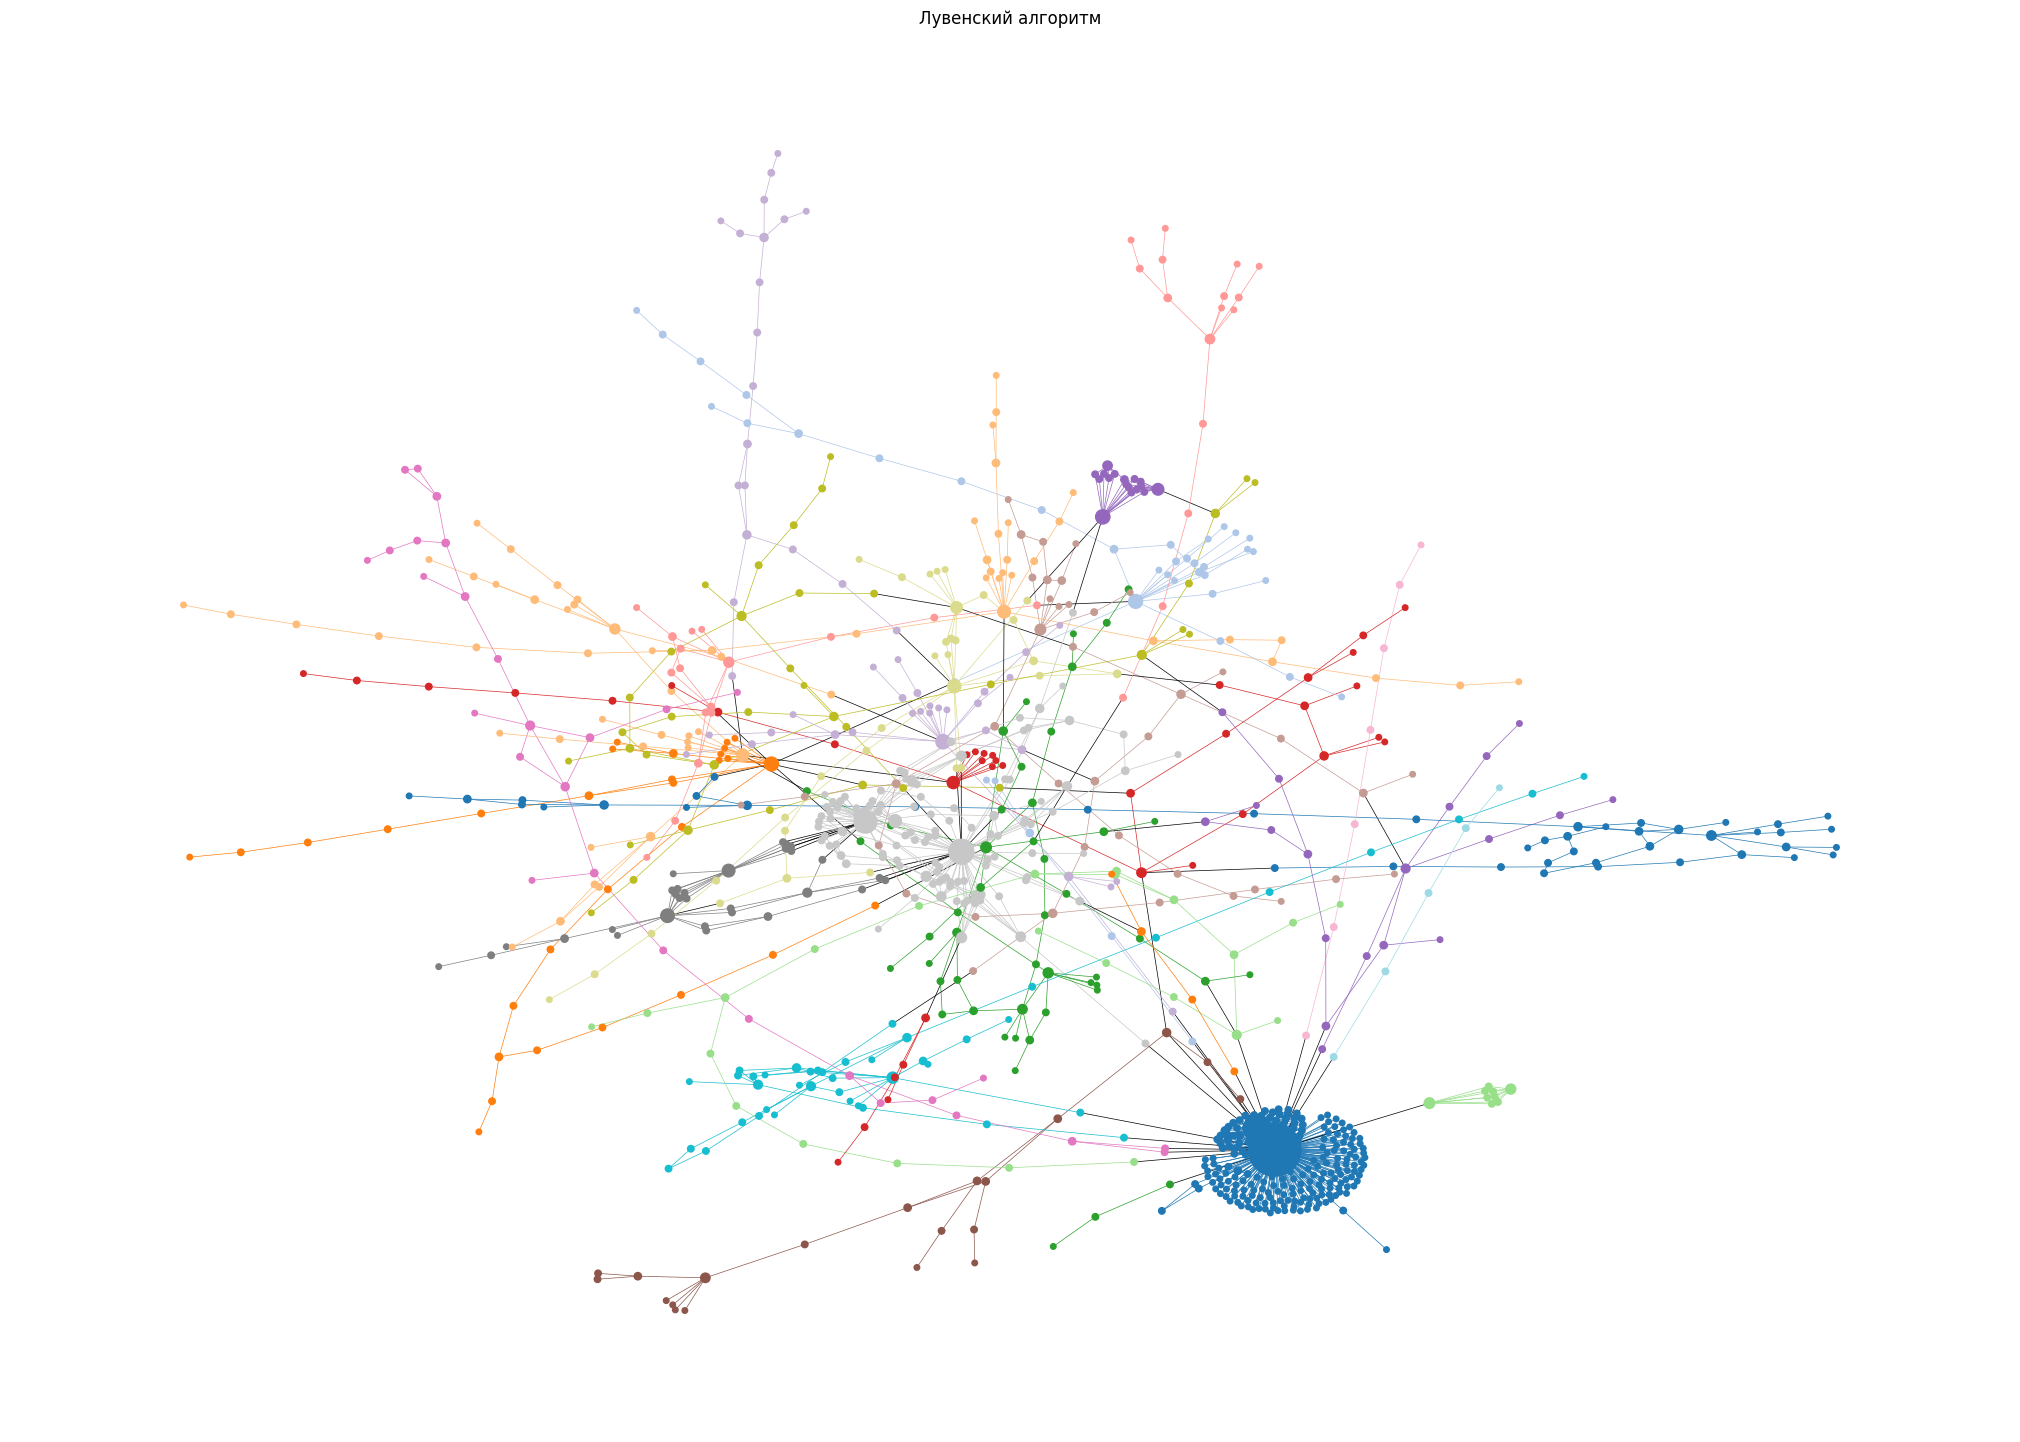

In [14]:
start = time.time()
communities = louvain_communities(G)
end_la = time.time() - start

colors = plt.cm.tab20.colors

node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title("Лувенский алгоритм")
plt.show()

In [15]:
# метка для каждой вершины узел:метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_la)

results.loc[len(results)] = ['Лувенский алгоритм',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_la, 5)]

Модулярность: 0.8471184153407697
Коэффициент силуэта: 0.32666564
Индекс Калински-Харабаша: 74.13635940673892
Индекс Дэвиcа-Боулдина: 1.2112769796636071
Время выполнения 0.03254079818725586


## 2) Алгоритм Гирвана-Ньюмена

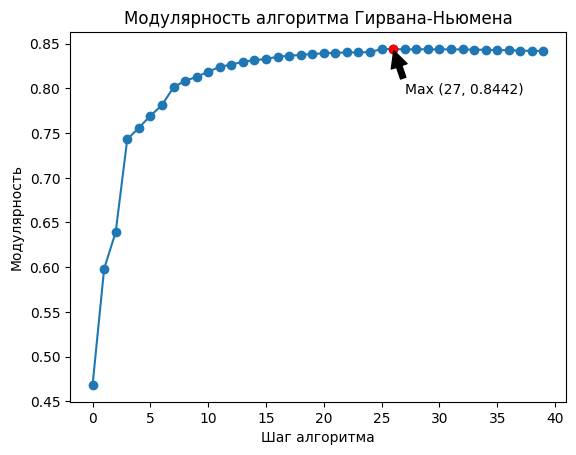

In [16]:
start = time.time()
communities_generator = girvan_newman(G)

modularity_values = []
optimal_communities_gn = []
max_modularity_index = None
counter = 0

for i, communities in enumerate(communities_generator):
    current_modularity = modularity(G, communities)
    modularity_values.append(current_modularity)

    if max_modularity_index is None or current_modularity > modularity_values[max_modularity_index]:
        max_modularity_index = i
        optimal_communities_gn = communities

    counter += 1
    if counter >= 40:
        break

end_gn1 = time.time() - start

plt.plot(modularity_values, marker='o')
plt.xlabel("Шаг алгоритма")
plt.ylabel("Модулярность")
plt.title("Модулярность алгоритма Гирвана-Ньюмена")

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index, modularity_values[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 1}, {modularity_values[max_modularity_index]:.4f})',
             xy=(max_modularity_index, modularity_values[max_modularity_index]),
             xytext=(max_modularity_index + 1, modularity_values[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

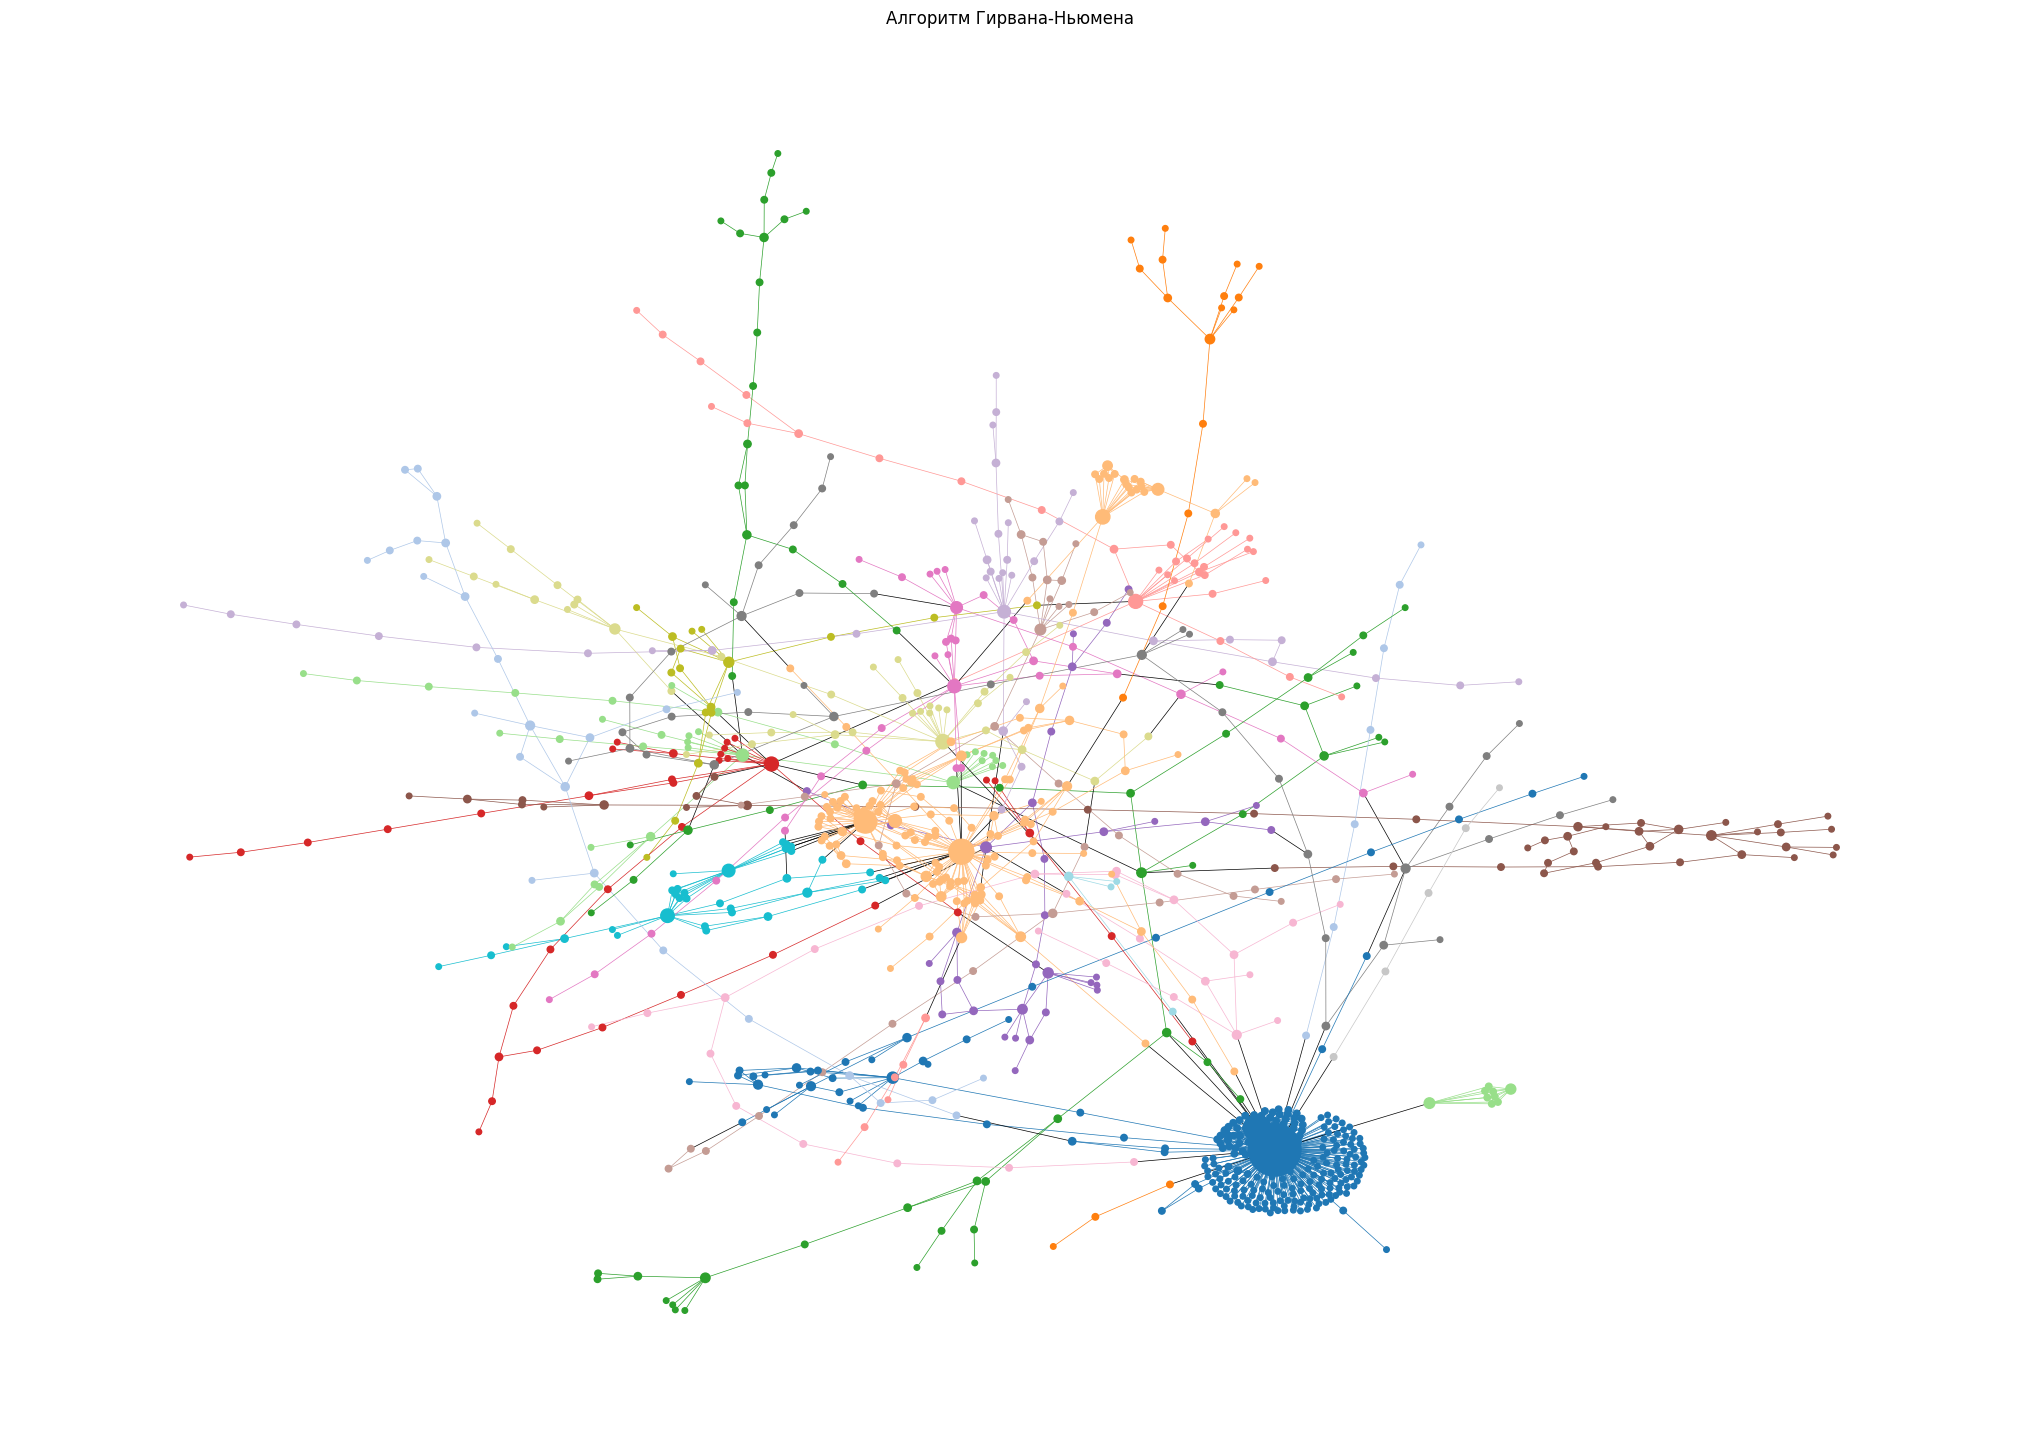

In [17]:
colors = plt.cm.tab20.colors

node_color_dict = {}
for i, community in enumerate(optimal_communities_gn):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title(f"Алгоритм Гирвана-Ньюмена")
plt.show()

In [18]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(optimal_communities_gn):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

modularity_value = modularity(G, optimal_communities_gn)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_gn1)

results.loc[len(results)] = ['Алгоритм Гирвана-Ньюмена',
                             len(optimal_communities_gn),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_gn1, 5)]

Модулярность: 0.8442263151792626
Коэффициент силуэта: 0.3129313
Индекс Калински-Харабаша: 72.86607891763948
Индекс Дэвиcа-Боулдина: 1.3090570433249884
Время выполнения 35.15133285522461


## 3) Greedy Modularity Maximization

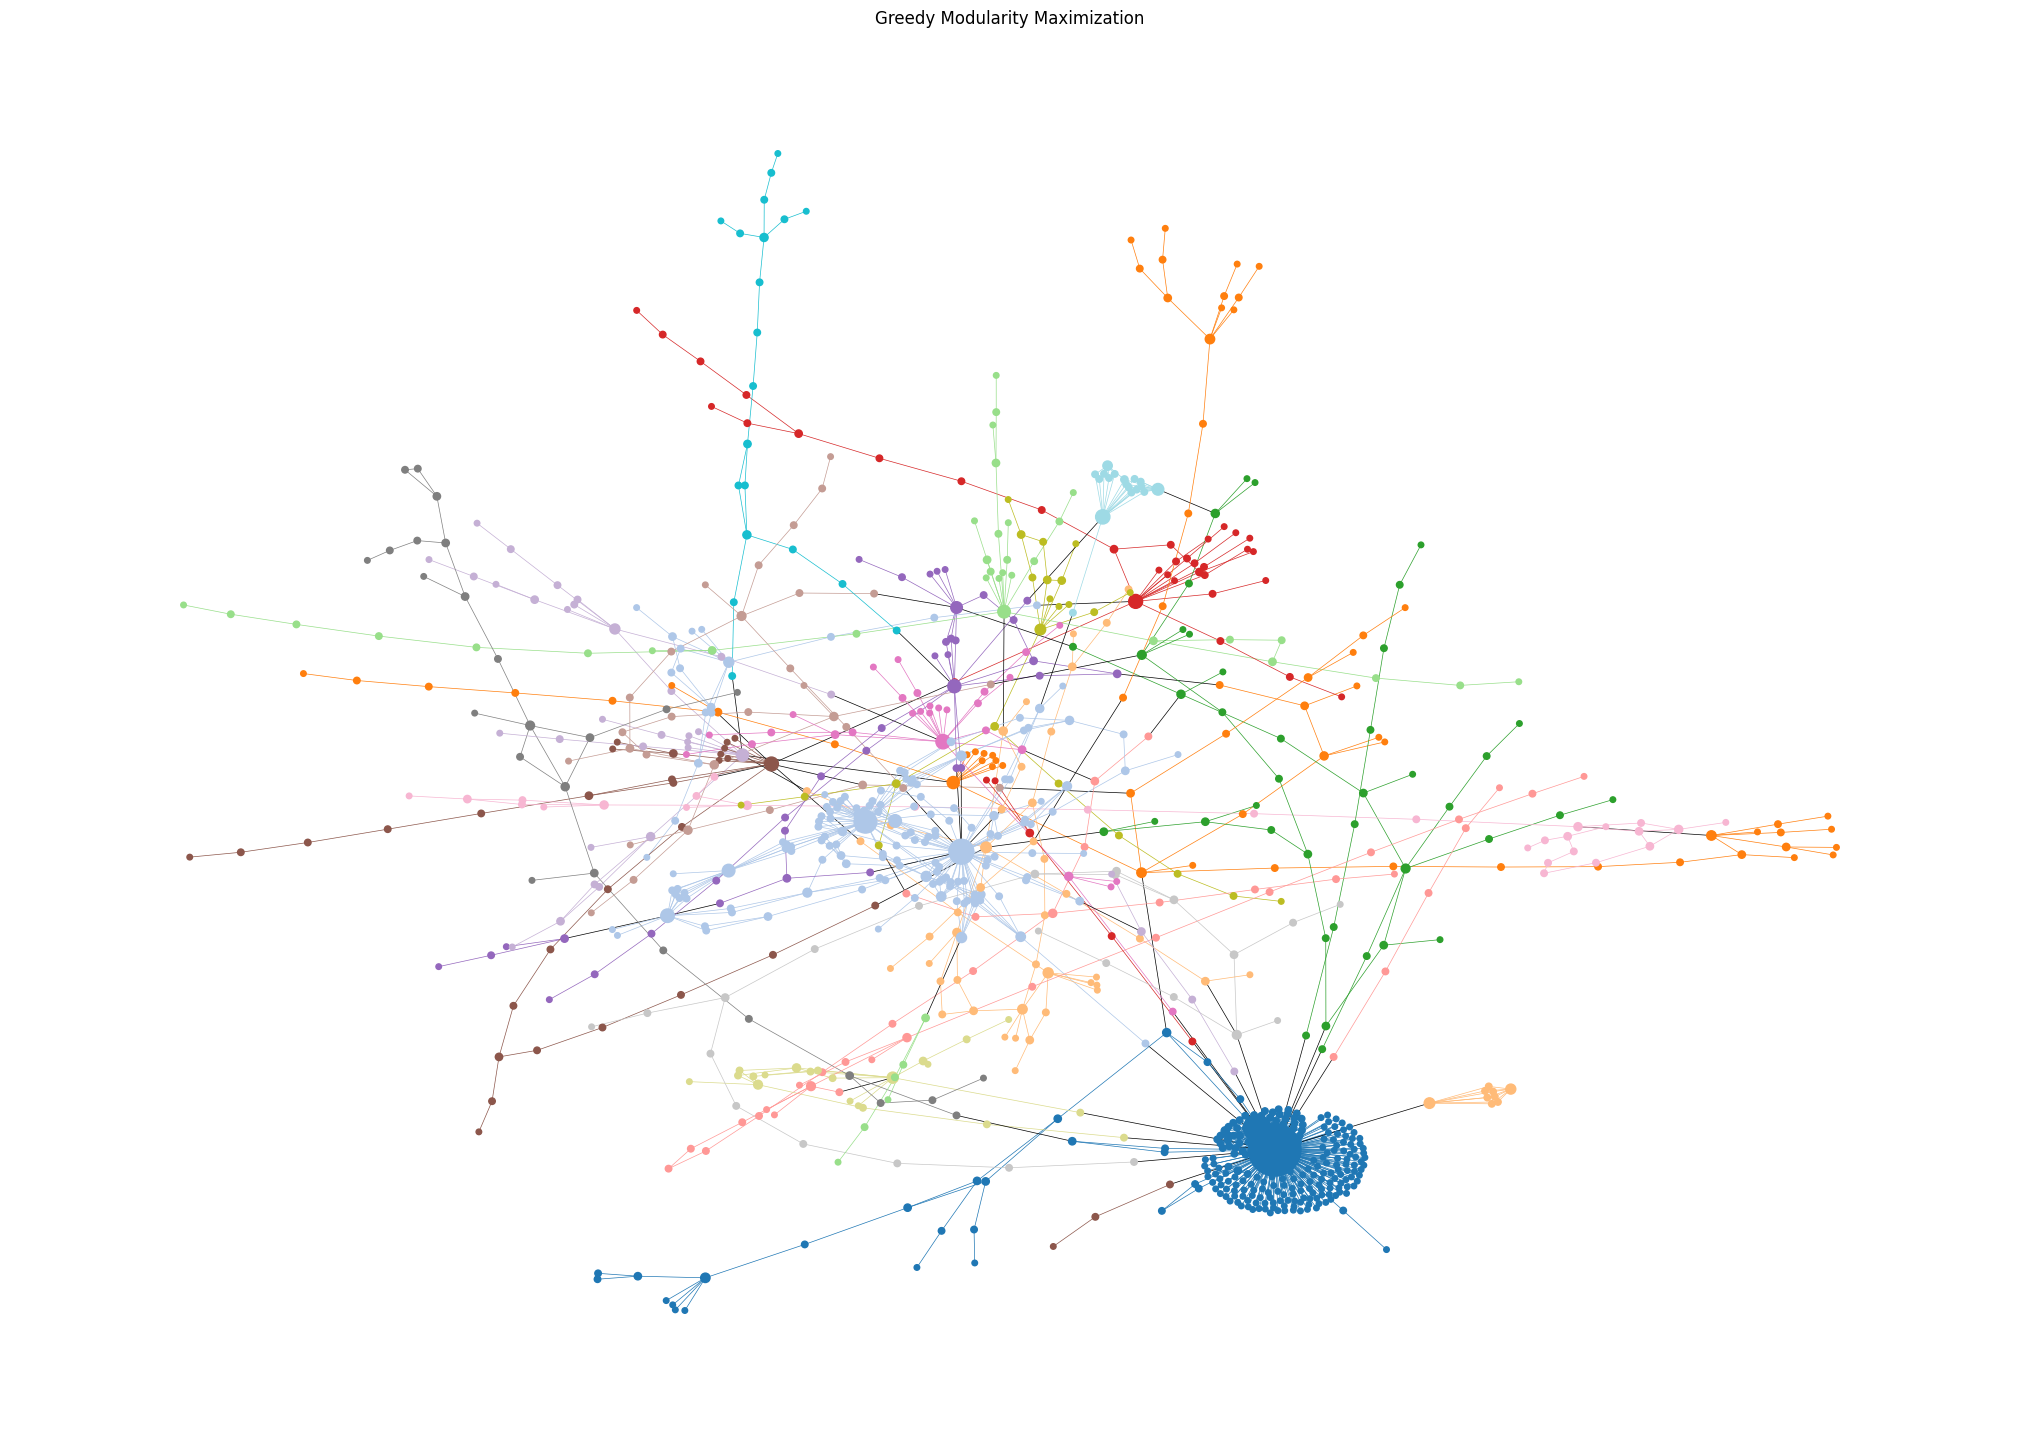

In [19]:
start = time.time()

communities = greedy_modularity_communities(G)
end_gm = time.time() - start

colors = plt.cm.tab20.colors
node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title("Greedy Modularity Maximization")
plt.show()

In [20]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список емток
labels = [node_to_community[node] for node in G.nodes()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_gm)

results.loc[len(results)] = ['Greedy Modularity Maximization',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_gm, 5)]

Модулярность: 0.8437322213863746
Коэффициент силуэта: 0.33505145
Индекс Калински-Харабаша: 72.8990970435373
Индекс Дэвиcа-Боулдина: 1.2171722889056025
Время выполнения 0.268233060836792


## 4) Asynchronous LPA

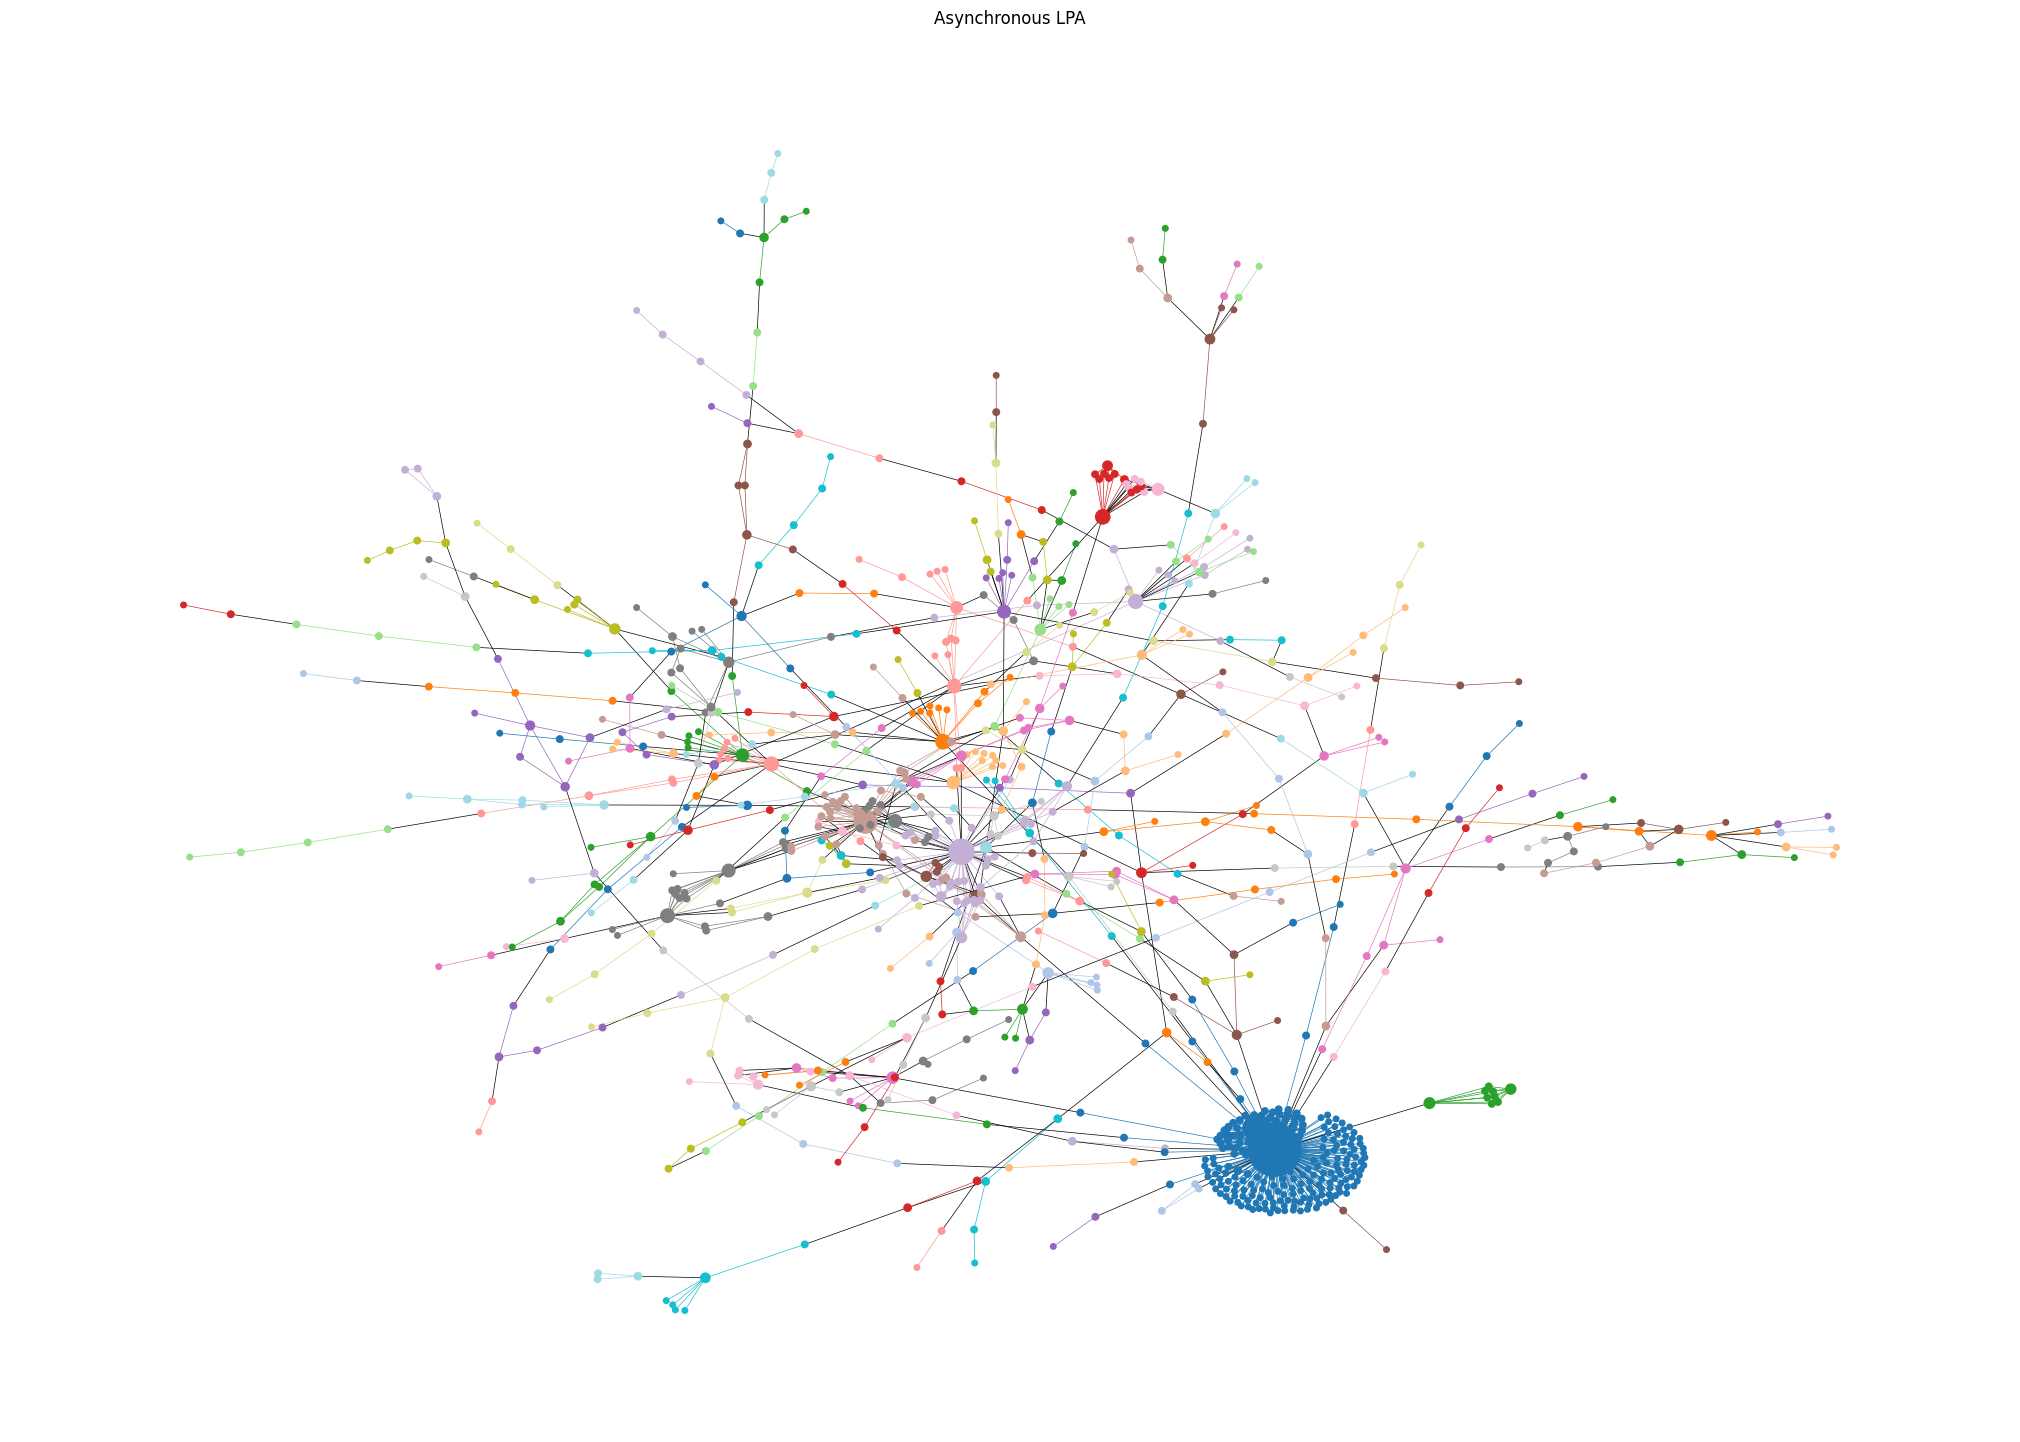

In [21]:
start = time.time()
communities = list(asyn_lpa_communities(G))
end_asyn_lpa = time.time() - start

colors = plt.cm.tab20.colors
node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Asynchronous LPA')
plt.show()

In [22]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print("Время выполнения", end_asyn_lpa)

results.loc[len(results)] = ['Asynchronous LPA',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_asyn_lpa, 5)]

Модулярность: 0.6706190799744408
Коэффициент силуэта: 0.32681534
Индекс Калински-Харабаша: 55.805502689403134
Индекс Дэвиcа-Боулдина: 0.8796579396244614
Время выполнения 0.03885006904602051


## 5) Synchronous LPA

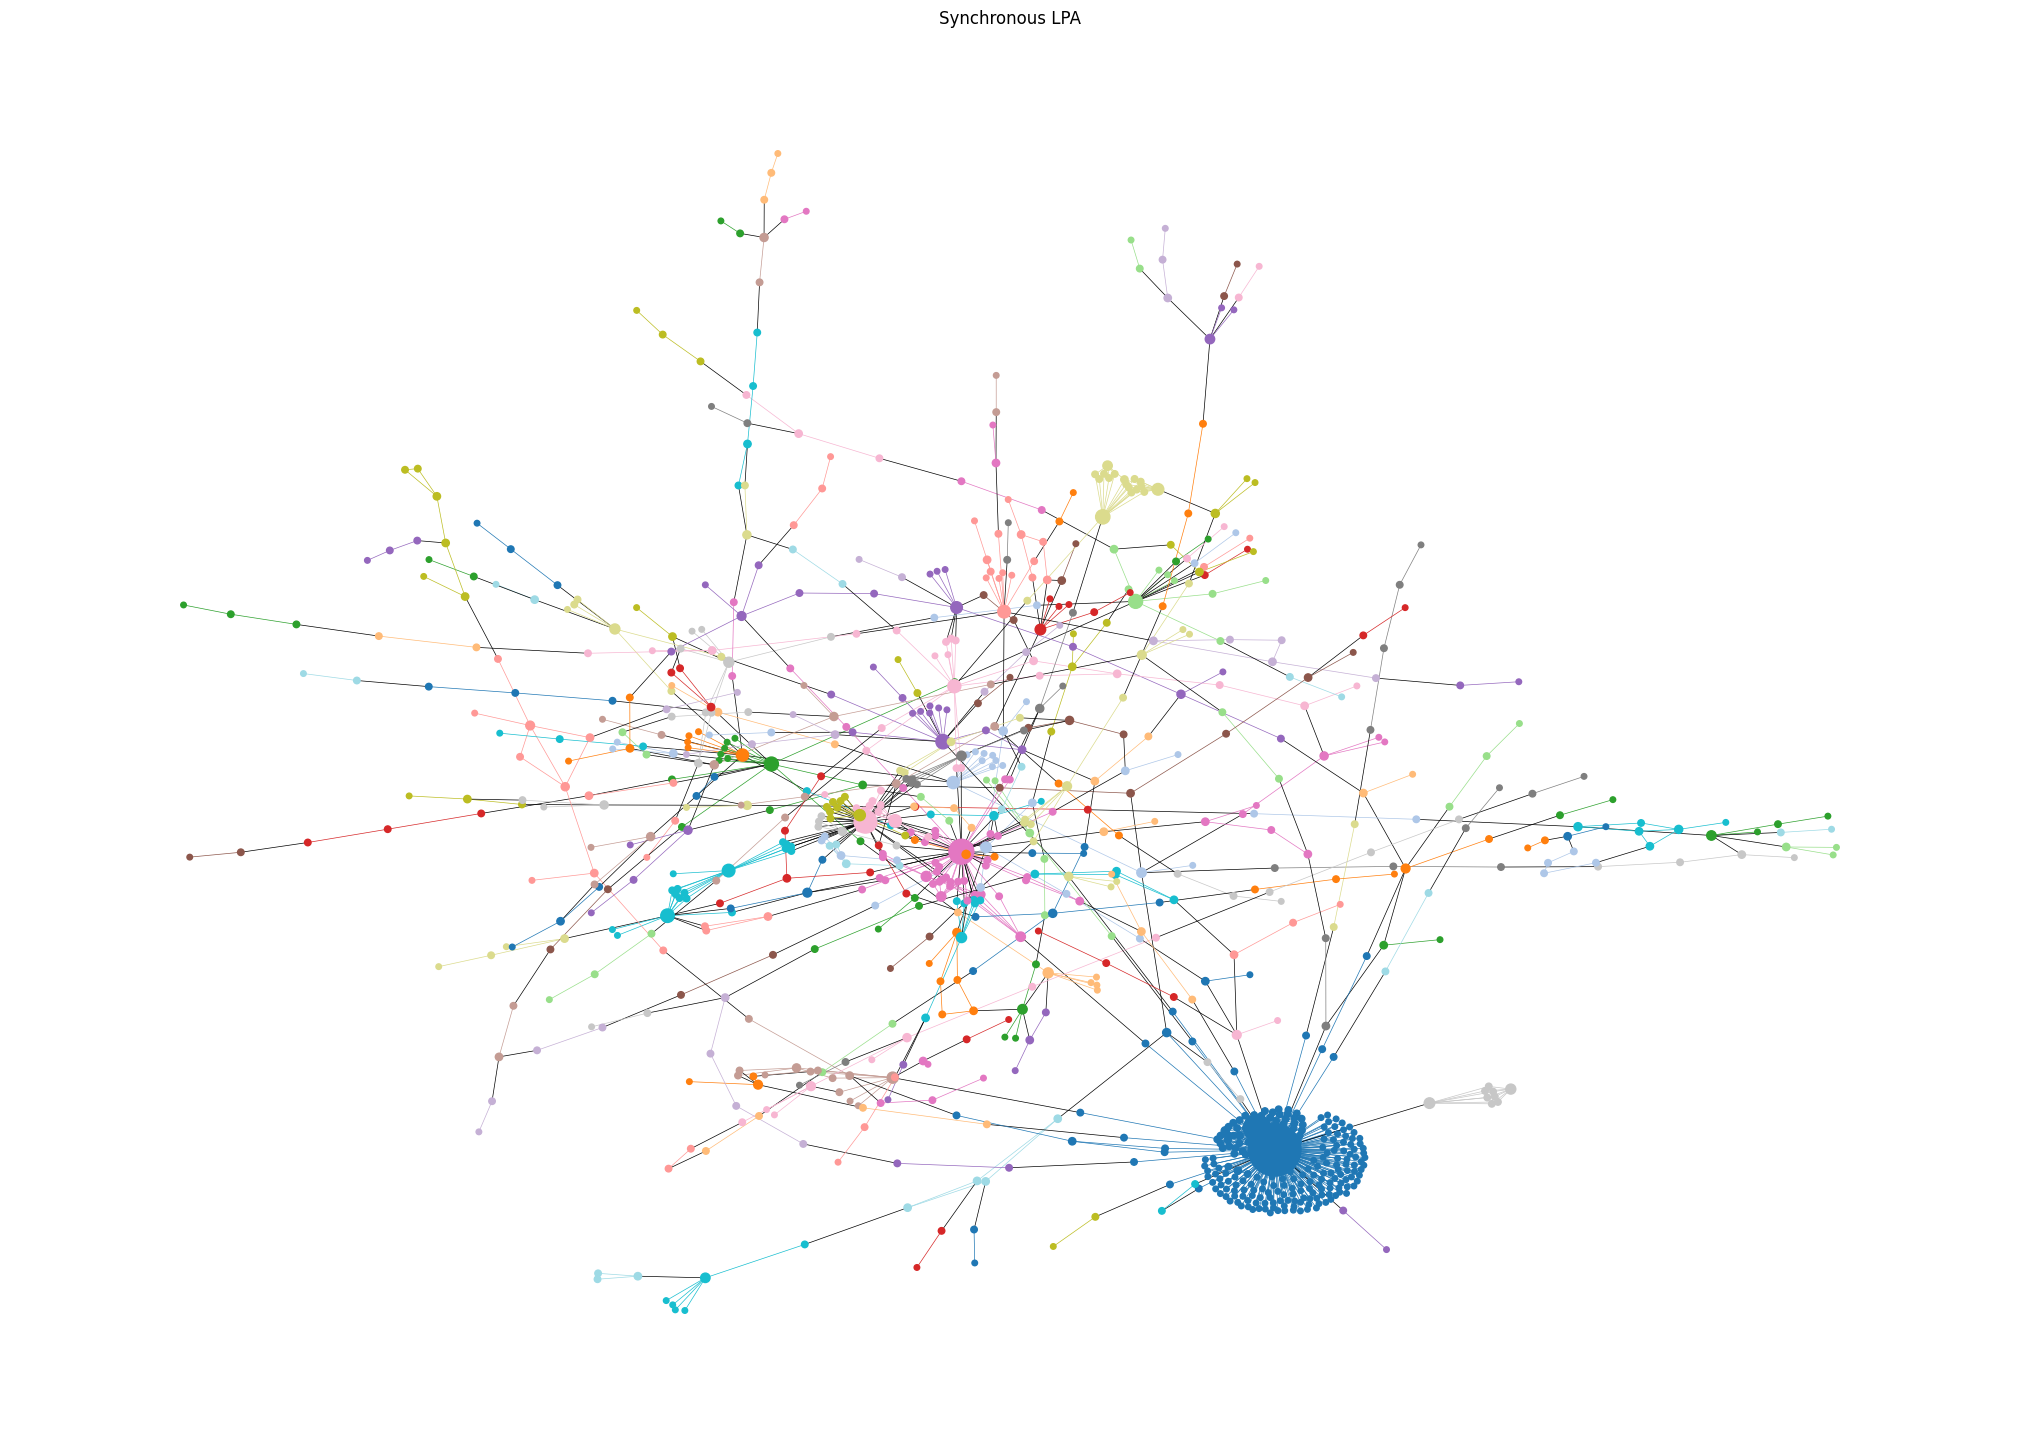

In [23]:
start = time.time()
communities = list(label_propagation_communities(G))
end_syn_lpa = time.time() - start

colors = plt.cm.tab20.colors
node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Synchronous LPA')
plt.show()

In [24]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_syn_lpa)

results.loc[len(results)] = ['Synchronous LPA',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_syn_lpa, 5)]

Модулярность: 0.6747791070451188
Коэффициент силуэта: 0.33660343
Индекс Калински-Харабаша: 53.63042581254804
Индекс Дэвиcа-Боулдина: 0.843158245600421
Время выполнения 0.06118202209472656


## 6) Fluid Communities

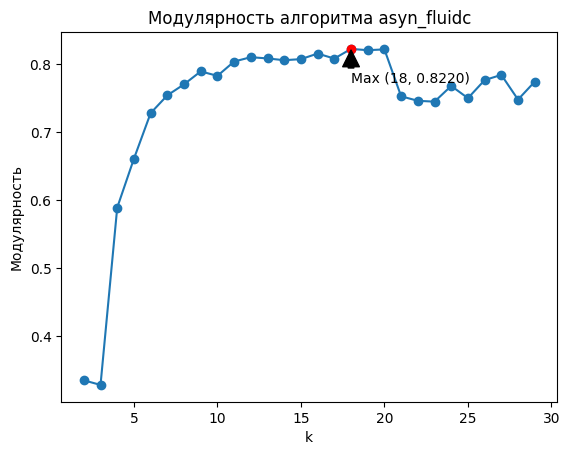

In [25]:
modularity_values = []
optimal_communities = []
max_modularity_index = None

for k in range(2, 30):
    communities = asyn_fluidc(G, k=k, seed=63)

    modularity_value = modularity(G, communities)
    modularity_values.append(modularity_value)

    if max_modularity_index is None or modularity_value > modularity_values[max_modularity_index]:
        max_modularity_index = k - 2
        optimal_communities = communities

plt.plot(range(2, 30), modularity_values, marker='o')
plt.xlabel("k")
plt.ylabel("Модулярность")
plt.title("Модулярность алгоритма asyn_fluidc")

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_values[max_modularity_index], 'ro')

# Вывод оптимальной точки с аннотацией
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_values[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_values[max_modularity_index]),
             xytext=(max_modularity_index + 2, modularity_values[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

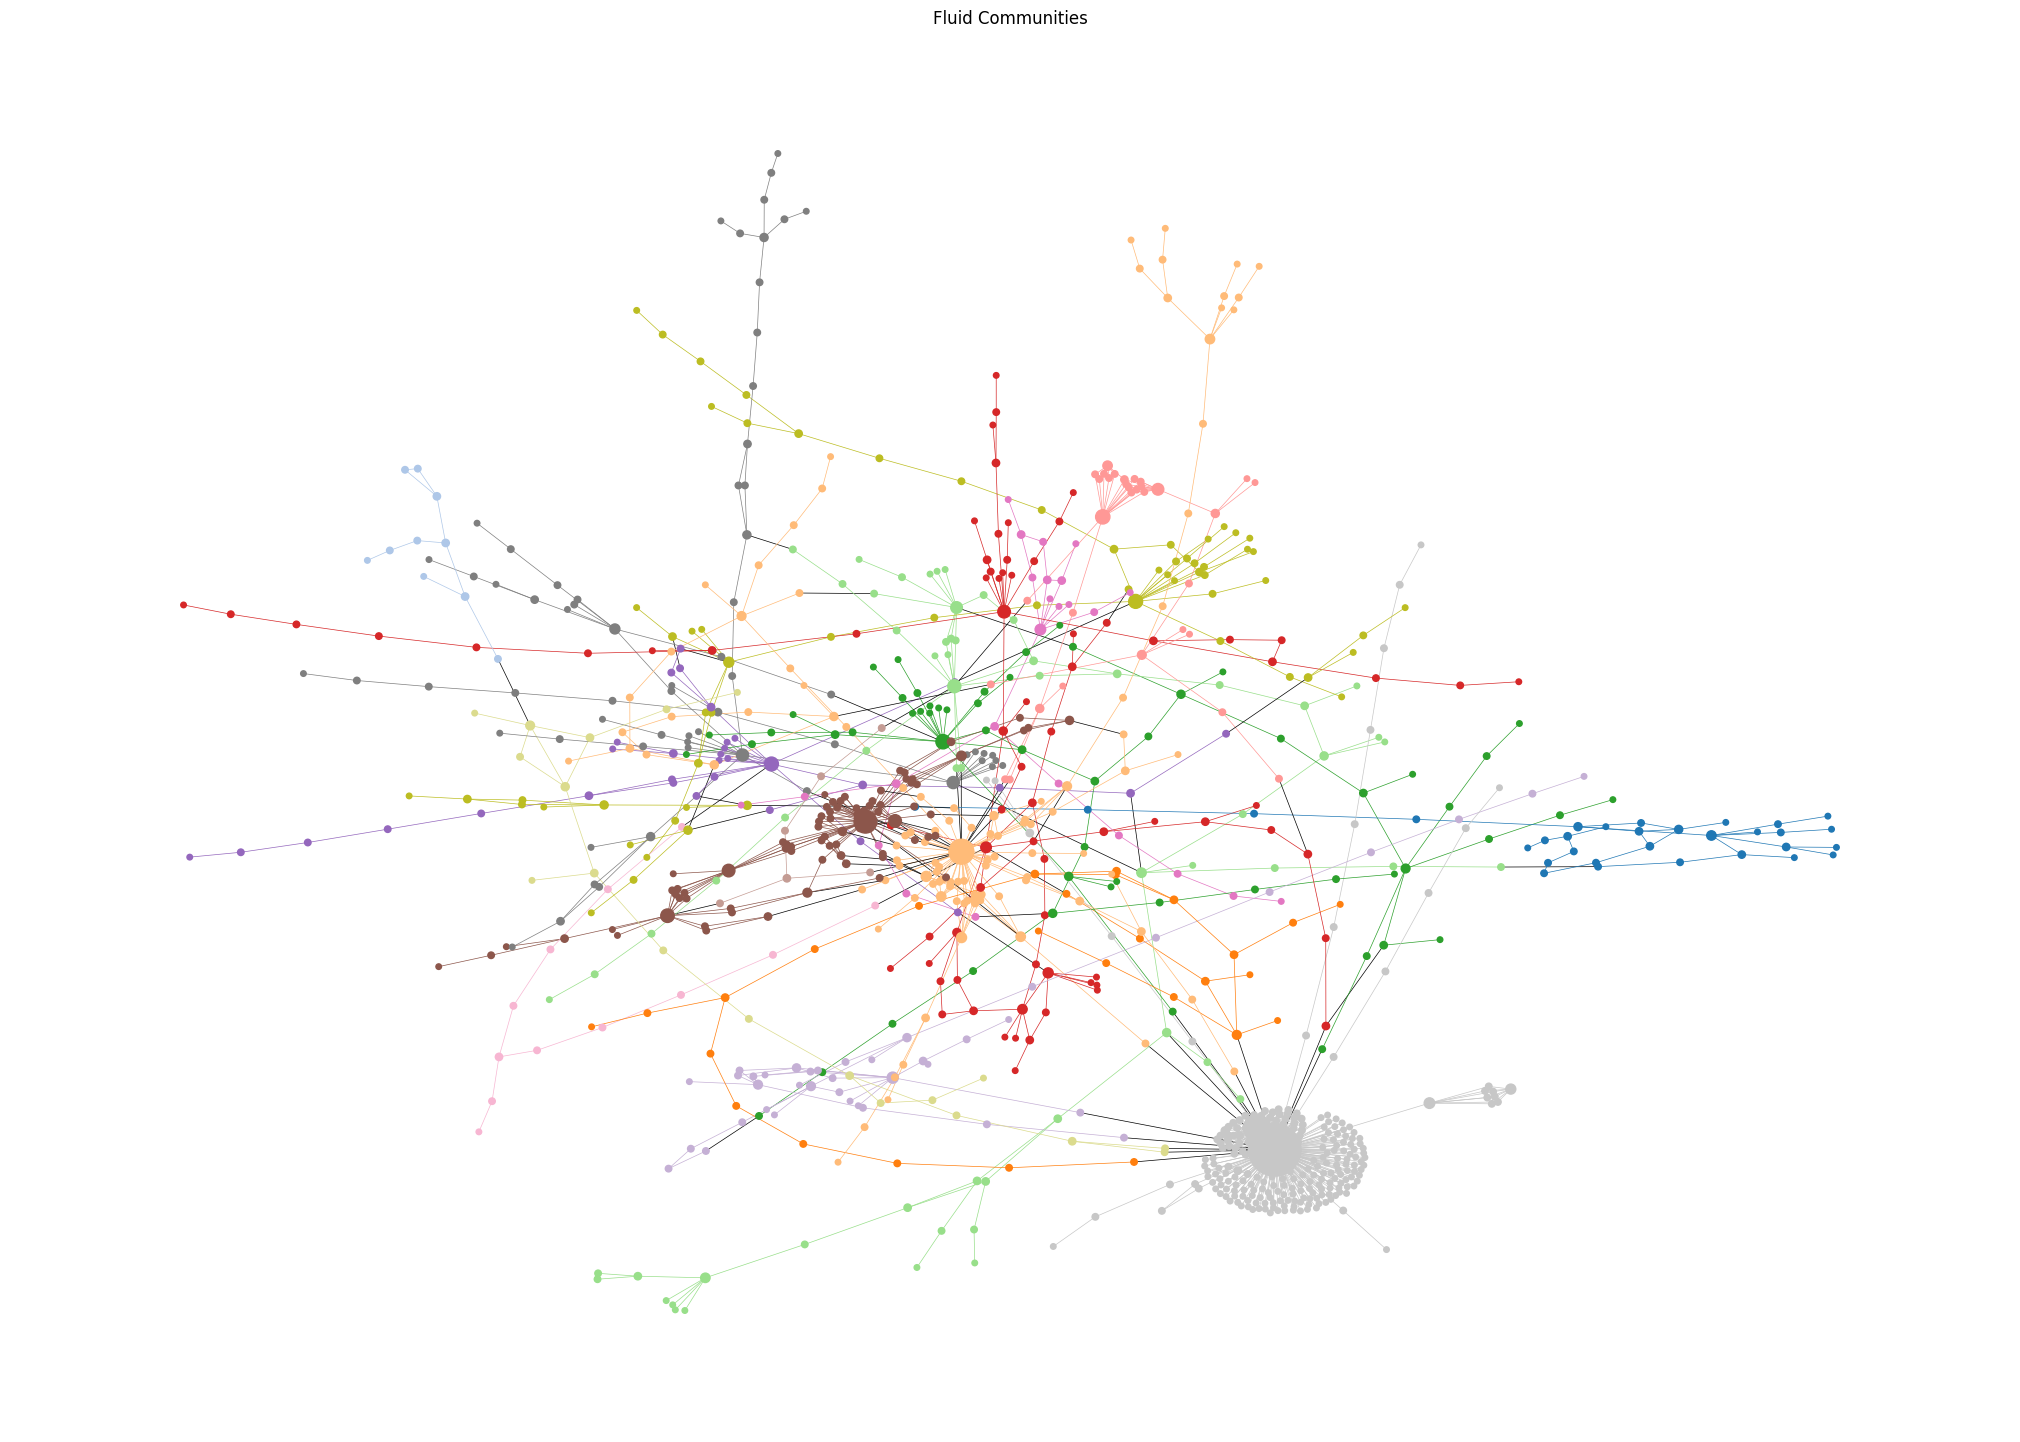

In [26]:
start = time.time()
communities = list(asyn_fluidc(G, k=18, seed=63))
end_asyn_fluidc = time.time() - start

colors = plt.cm.tab20.colors
node_color_dict = {}
for i, community in enumerate(communities):
    color = colors[i % len(colors)]
    for node in community:
        node_color_dict[node] = color

node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Fluid Communities')
plt.show()

In [27]:
# метка для каждой вершины узел-метка
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# список меток
labels = [node_to_community[node] for node in G.nodes()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_asyn_fluidc)

results.loc[len(results)] = ['Fluid Communities',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_asyn_fluidc, 5)]

Модулярность: 0.8219658057436213
Коэффициент силуэта: 0.26280394
Индекс Калински-Харабаша: 72.68281332419373
Индекс Дэвиcа-Боулдина: 1.6703369056053303
Время выполнения 0.057676076889038086


## 7) K-Means Clustering

### Метод локтя (Elbow Method)

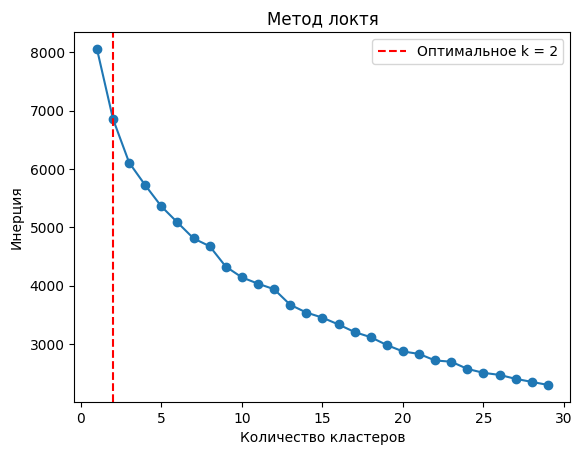

In [28]:
inertias = []

for k in range(1, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(node_vectors)
    inertias.append(kmeans.inertia_)

# Вычисляем первую производную инерции
differences = np.diff(inertias)

# Вычисляем вторую производную инерции
acceleration = np.diff(differences)

# Находим индекс, где вторая производная становится максимальной
optimal_k_index = np.argmax(acceleration) + 1  # добавляем 1, так как разница в длине массива
optimal_k = optimal_k_index + 1  # добавляем 1, так как индексация начинается с 0

# Визуализируем метод локтя
plt.plot(range(1, 30), inertias, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Оптимальное k = {optimal_k}')
plt.legend()
plt.show()

### Индекс силуэта (Silhouette Score)

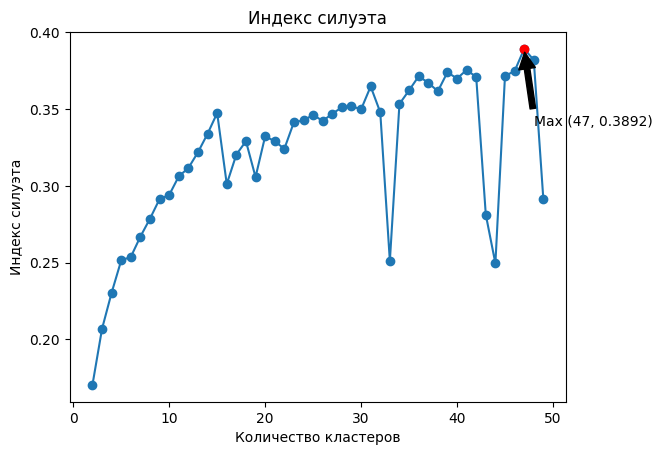

In [29]:
silhouette_scores = []

for k in range(2, 50):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(node_vectors)
    silhouette = silhouette_score(node_vectors, kmeans.labels_)
    silhouette_scores.append(silhouette)

plt.plot(range(2, 50), silhouette_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Индекс силуэта')
plt.title('Индекс силуэта')

# Находим индекс максимального значения силуэта
max_silhouette_index = silhouette_scores.index(max(silhouette_scores))

# Добавляем красную точку для максимального значения силуэта
plt.plot(max_silhouette_index + 2, silhouette_scores[max_silhouette_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_silhouette_index + 2}, {silhouette_scores[max_silhouette_index]:.4f})',
             xy=(max_silhouette_index + 2, silhouette_scores[max_silhouette_index]),
             xytext=(max_silhouette_index + 3, silhouette_scores[max_silhouette_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

### Модулярность

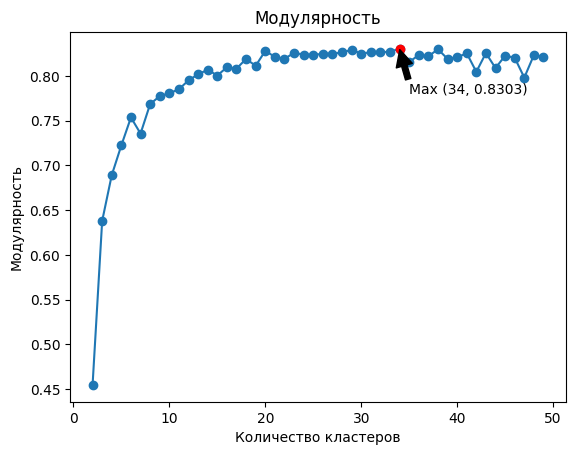

In [30]:
modularity_scores = []

for k in range(2, 50):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(node_vectors)
    labels = kmeans.labels_
    partition = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(k)]
    modularity_scores.append(modularity(G, partition))

plt.plot(range(2, 50), modularity_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Модулярность')
plt.title('Модулярность')

# Находим индекс максимального значения модулярности
max_modularity_index = modularity_scores.index(max(modularity_scores))

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_scores[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_scores[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_scores[max_modularity_index]),
             xytext=(max_modularity_index + 3, modularity_scores[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.02))

plt.show()

### Кластеризация

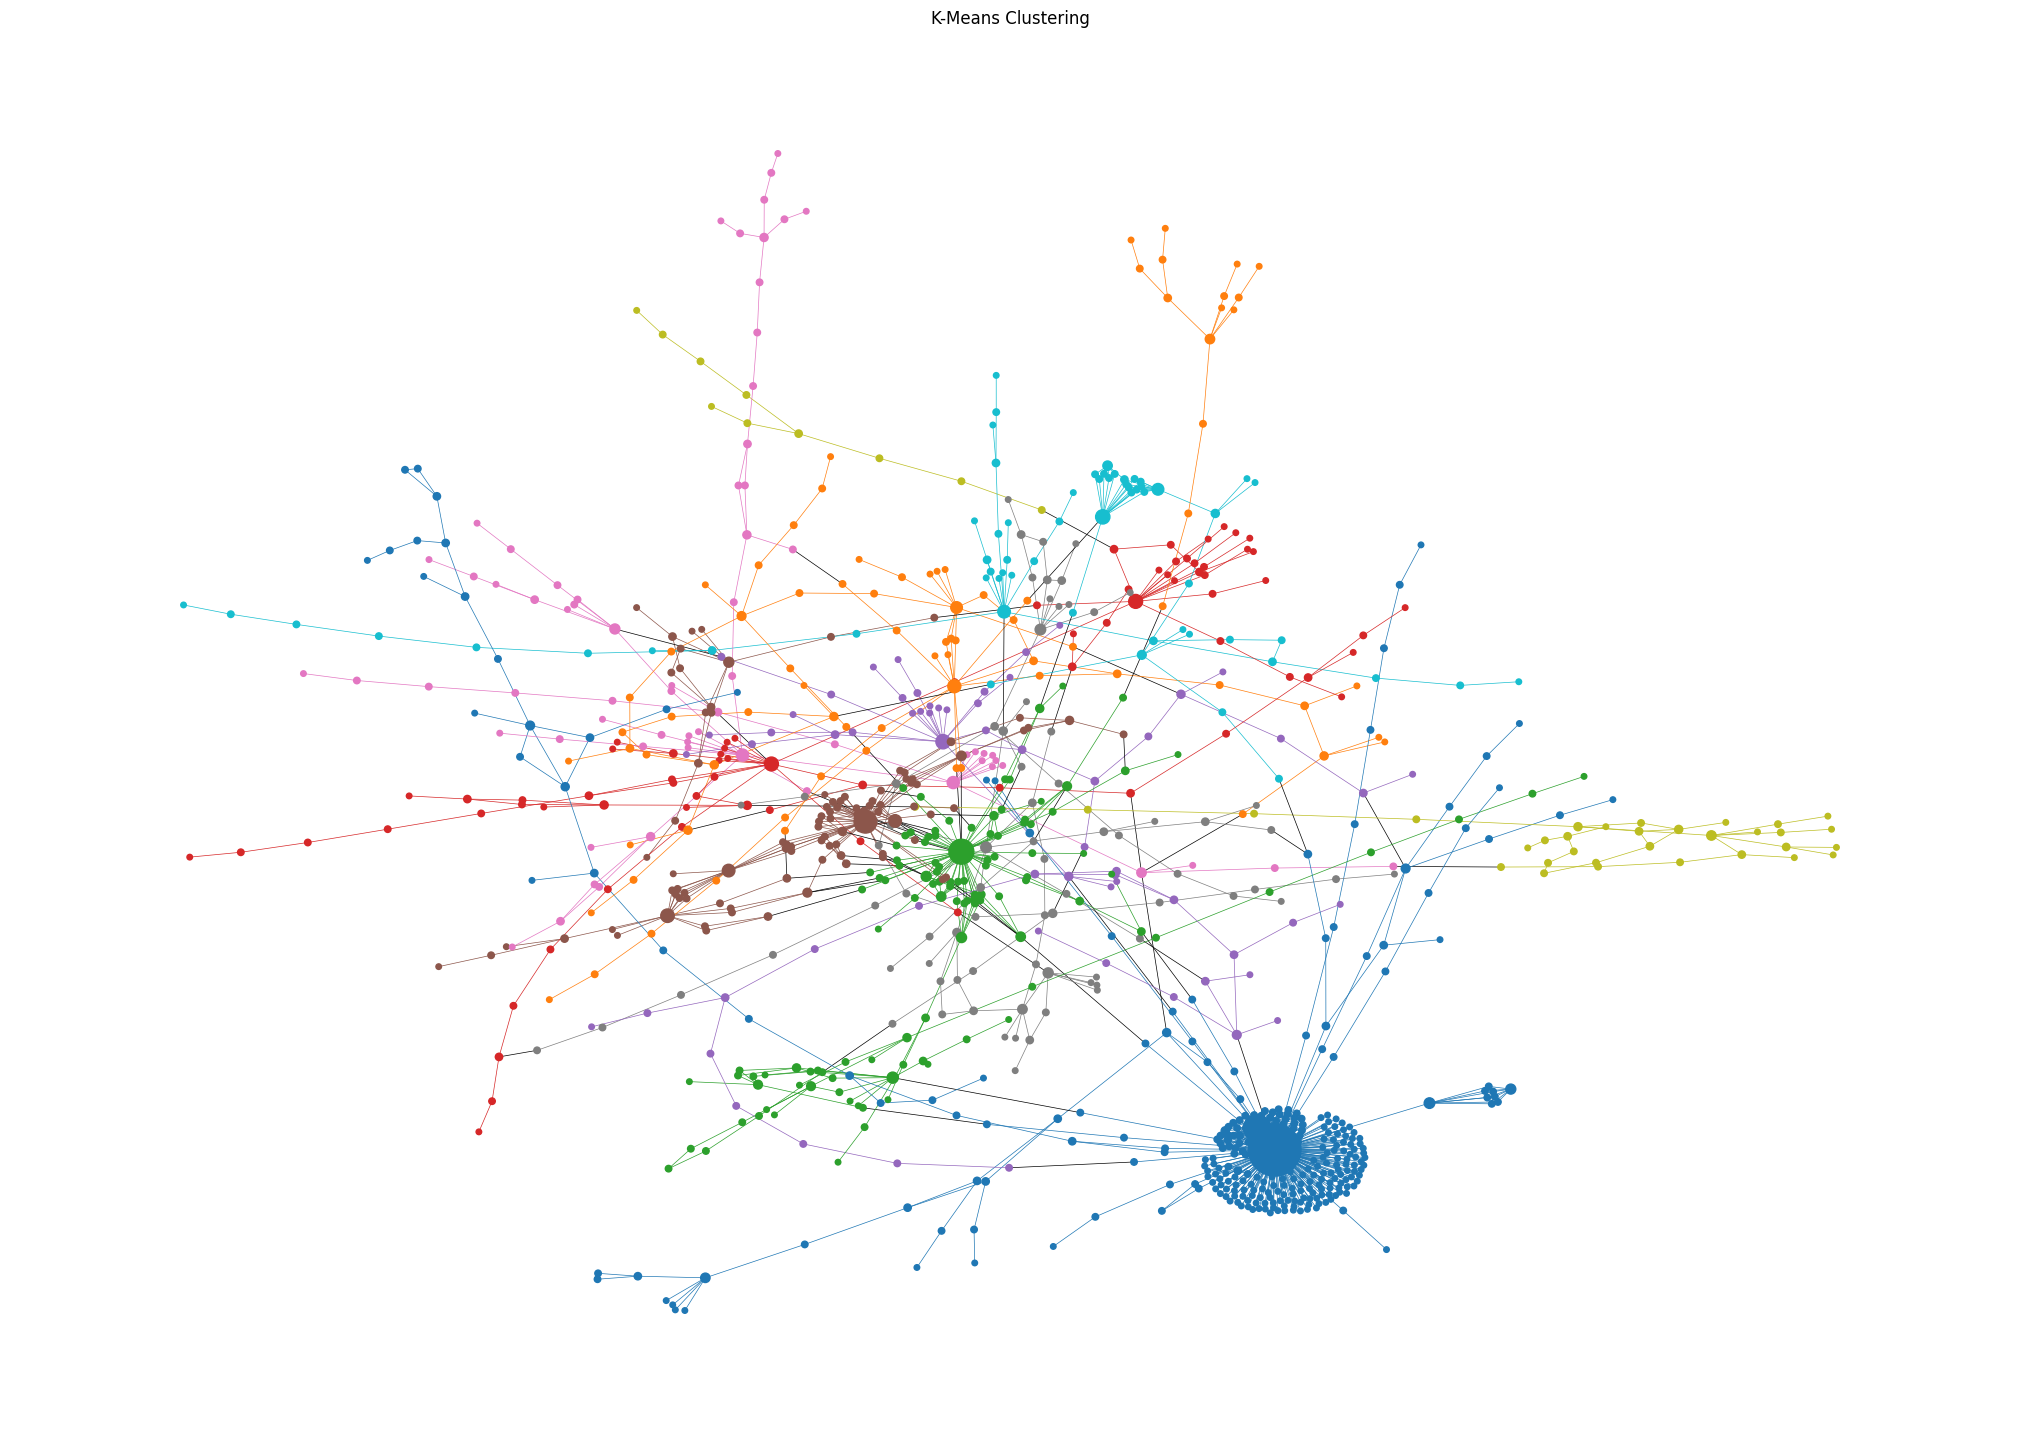

In [31]:
start = time.time()
n_clusters = 22
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(node_vectors)
labels = kmeans.labels_
end_kmeans = time.time() - start

colors = plt.cm.tab10.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('K-Means Clustering')
plt.show()

In [32]:
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_kmeans)

results.loc[len(results)] = ['K-Means Clustering',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_kmeans, 5)]

Модулярность: 0.8236385120833907
Коэффициент силуэта: 0.34308937
Индекс Калински-Харабаша: 91.48454322391242
Индекс Дэвиcа-Боулдина: 1.3112624415248246
Время выполнения 0.20883417129516602


## 8) DBSCAN

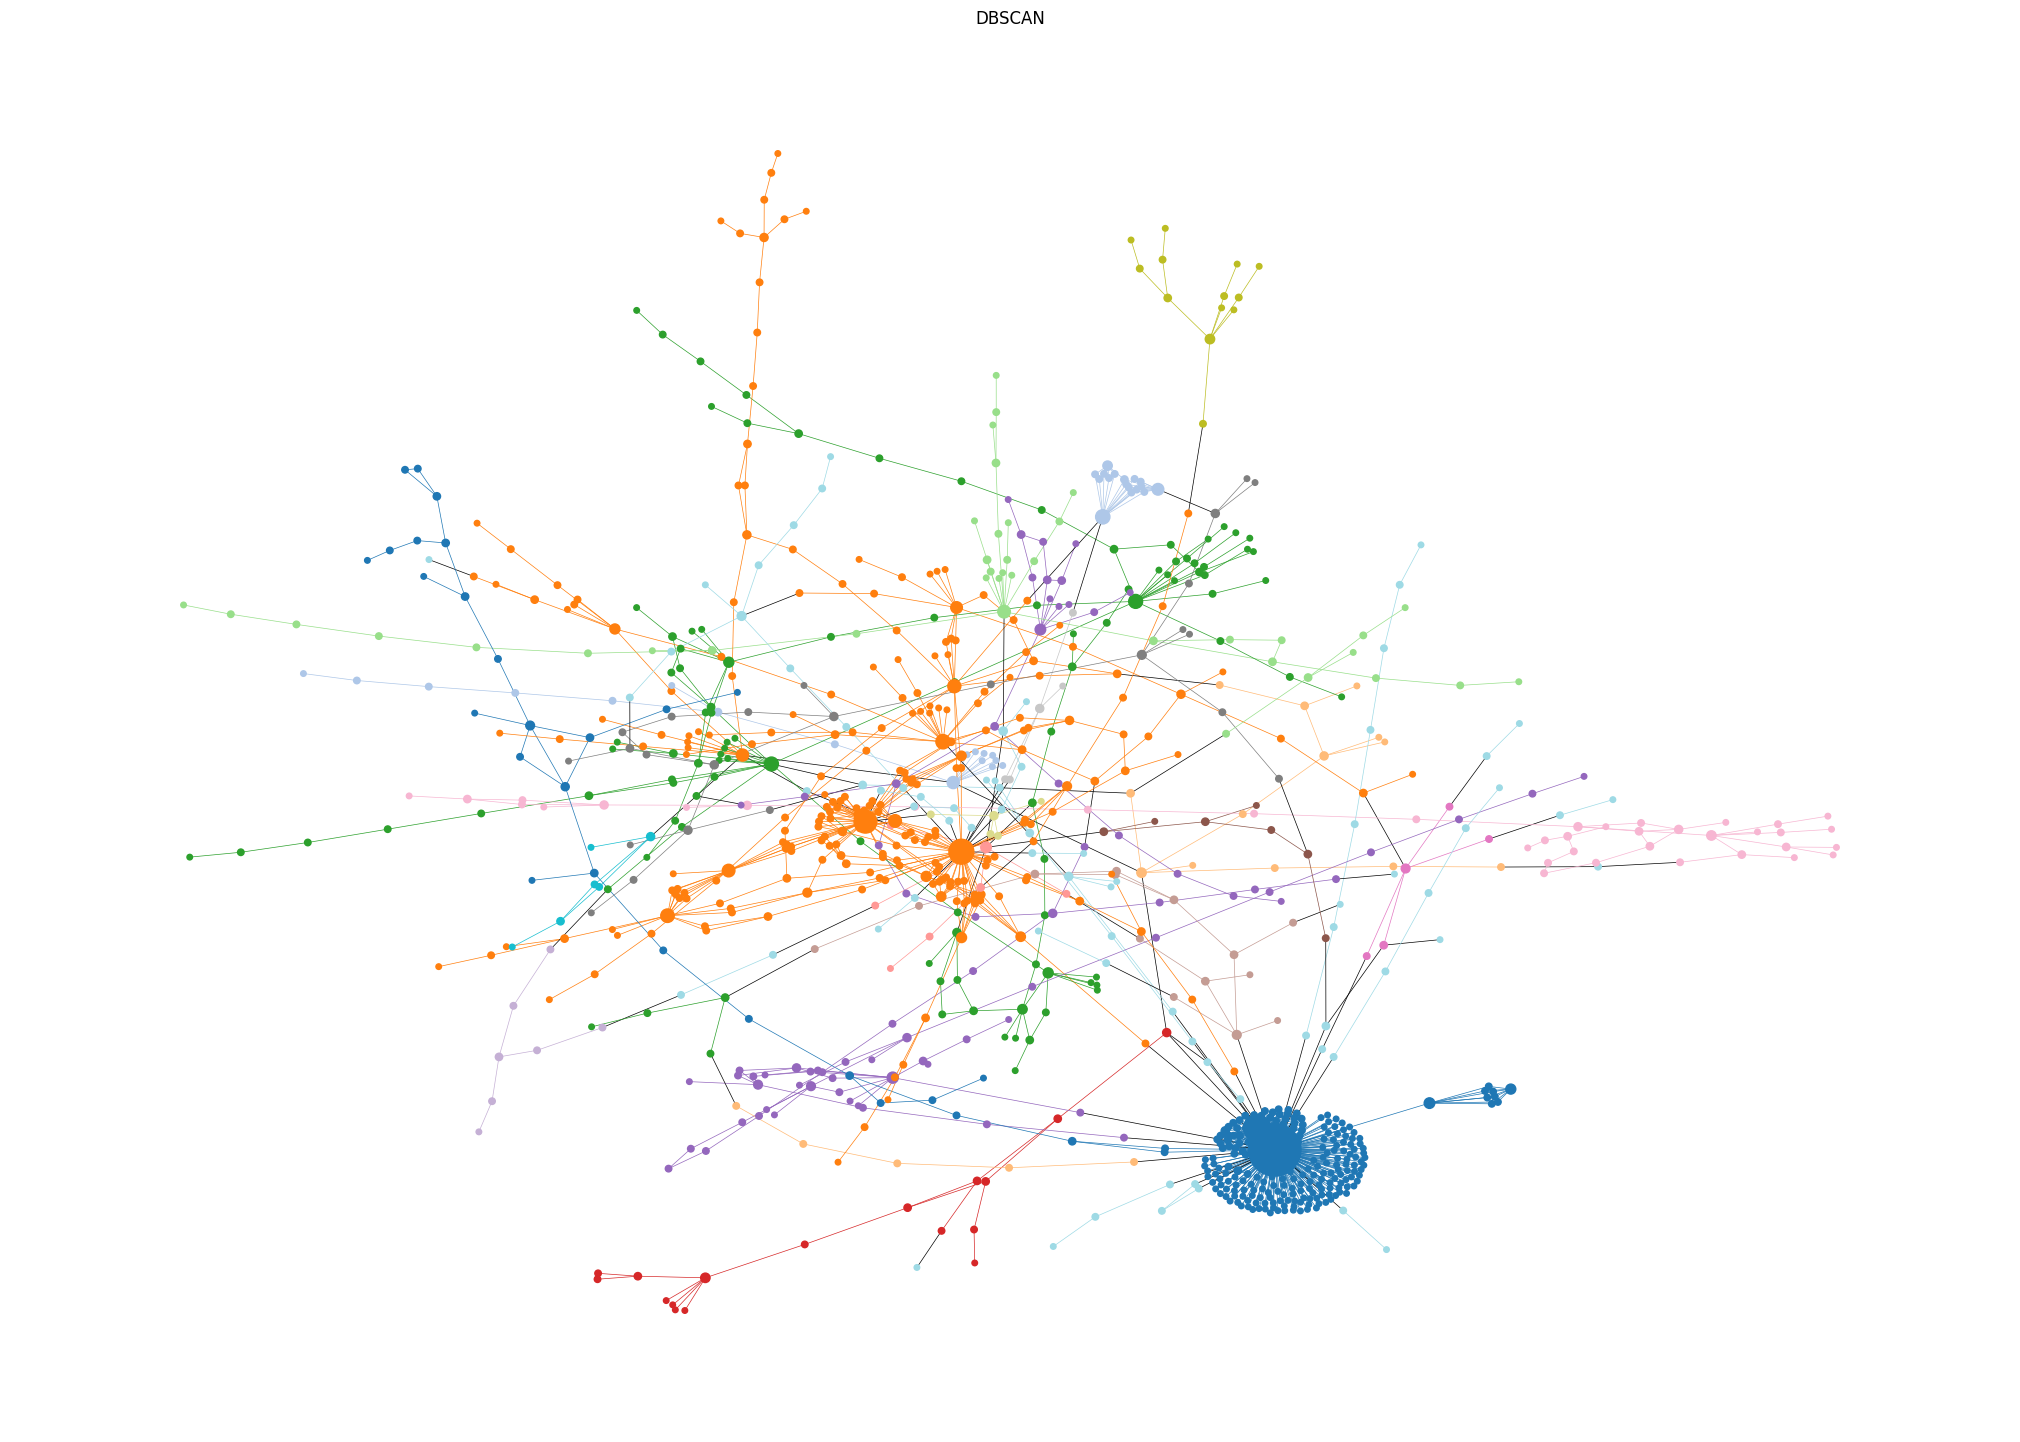

Количество кластеров: 26
Количество выбросов: 66


In [33]:
start = time.time()
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan.fit(node_vectors)

# Получаем метки кластеров
labels = dbscan.labels_

end_dbscan = time.time() - start

# Создаем словарь для цветов узлов
colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

# Определяем цвета рёбер
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('DBSCAN')
plt.show()

# Определяем количество кластеров и выбросов
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_outliers = list(labels).count(-1)

print("Количество кластеров:", n_clusters)
print("Количество выбросов:", n_outliers)

In [34]:
clusters = {}
for i, label in enumerate(labels):
    node_name = list(G.nodes)[i]
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(node_name)

communities = [set(cluster) for cluster in clusters.values()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print("Время выполнения", end_dbscan)

results.loc[len(results)] = ['DBSCAN',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_dbscan, 5)]

Модулярность: 0.7653543185010826
Коэффициент силуэта: 0.17407736
Индекс Калински-Харабаша: 36.2511192384301
Индекс Дэвиcа-Боулдина: 1.6366375735168774
Время выполнения 0.027137041091918945


## 9) Agglomerative Clustering

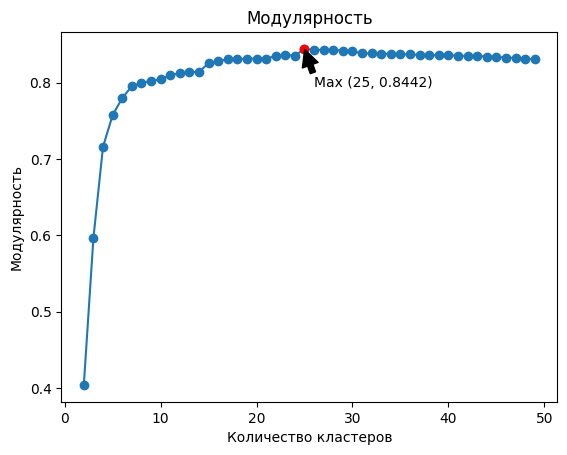

In [35]:
modularity_scores = []

for k in range(2, 50):
    kmeans = AgglomerativeClustering(n_clusters=k)
    kmeans.fit(node_vectors)
    labels = kmeans.labels_
    partition = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(k)]
    modularity_scores.append(modularity(G, partition))

plt.plot(range(2, 50), modularity_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Модулярность')
plt.title('Модулярность')

# Находим индекс максимального значения модулярности
max_modularity_index = modularity_scores.index(max(modularity_scores))

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_scores[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_scores[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_scores[max_modularity_index]),
             xytext=(max_modularity_index + 3, modularity_scores[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.02))

plt.show()

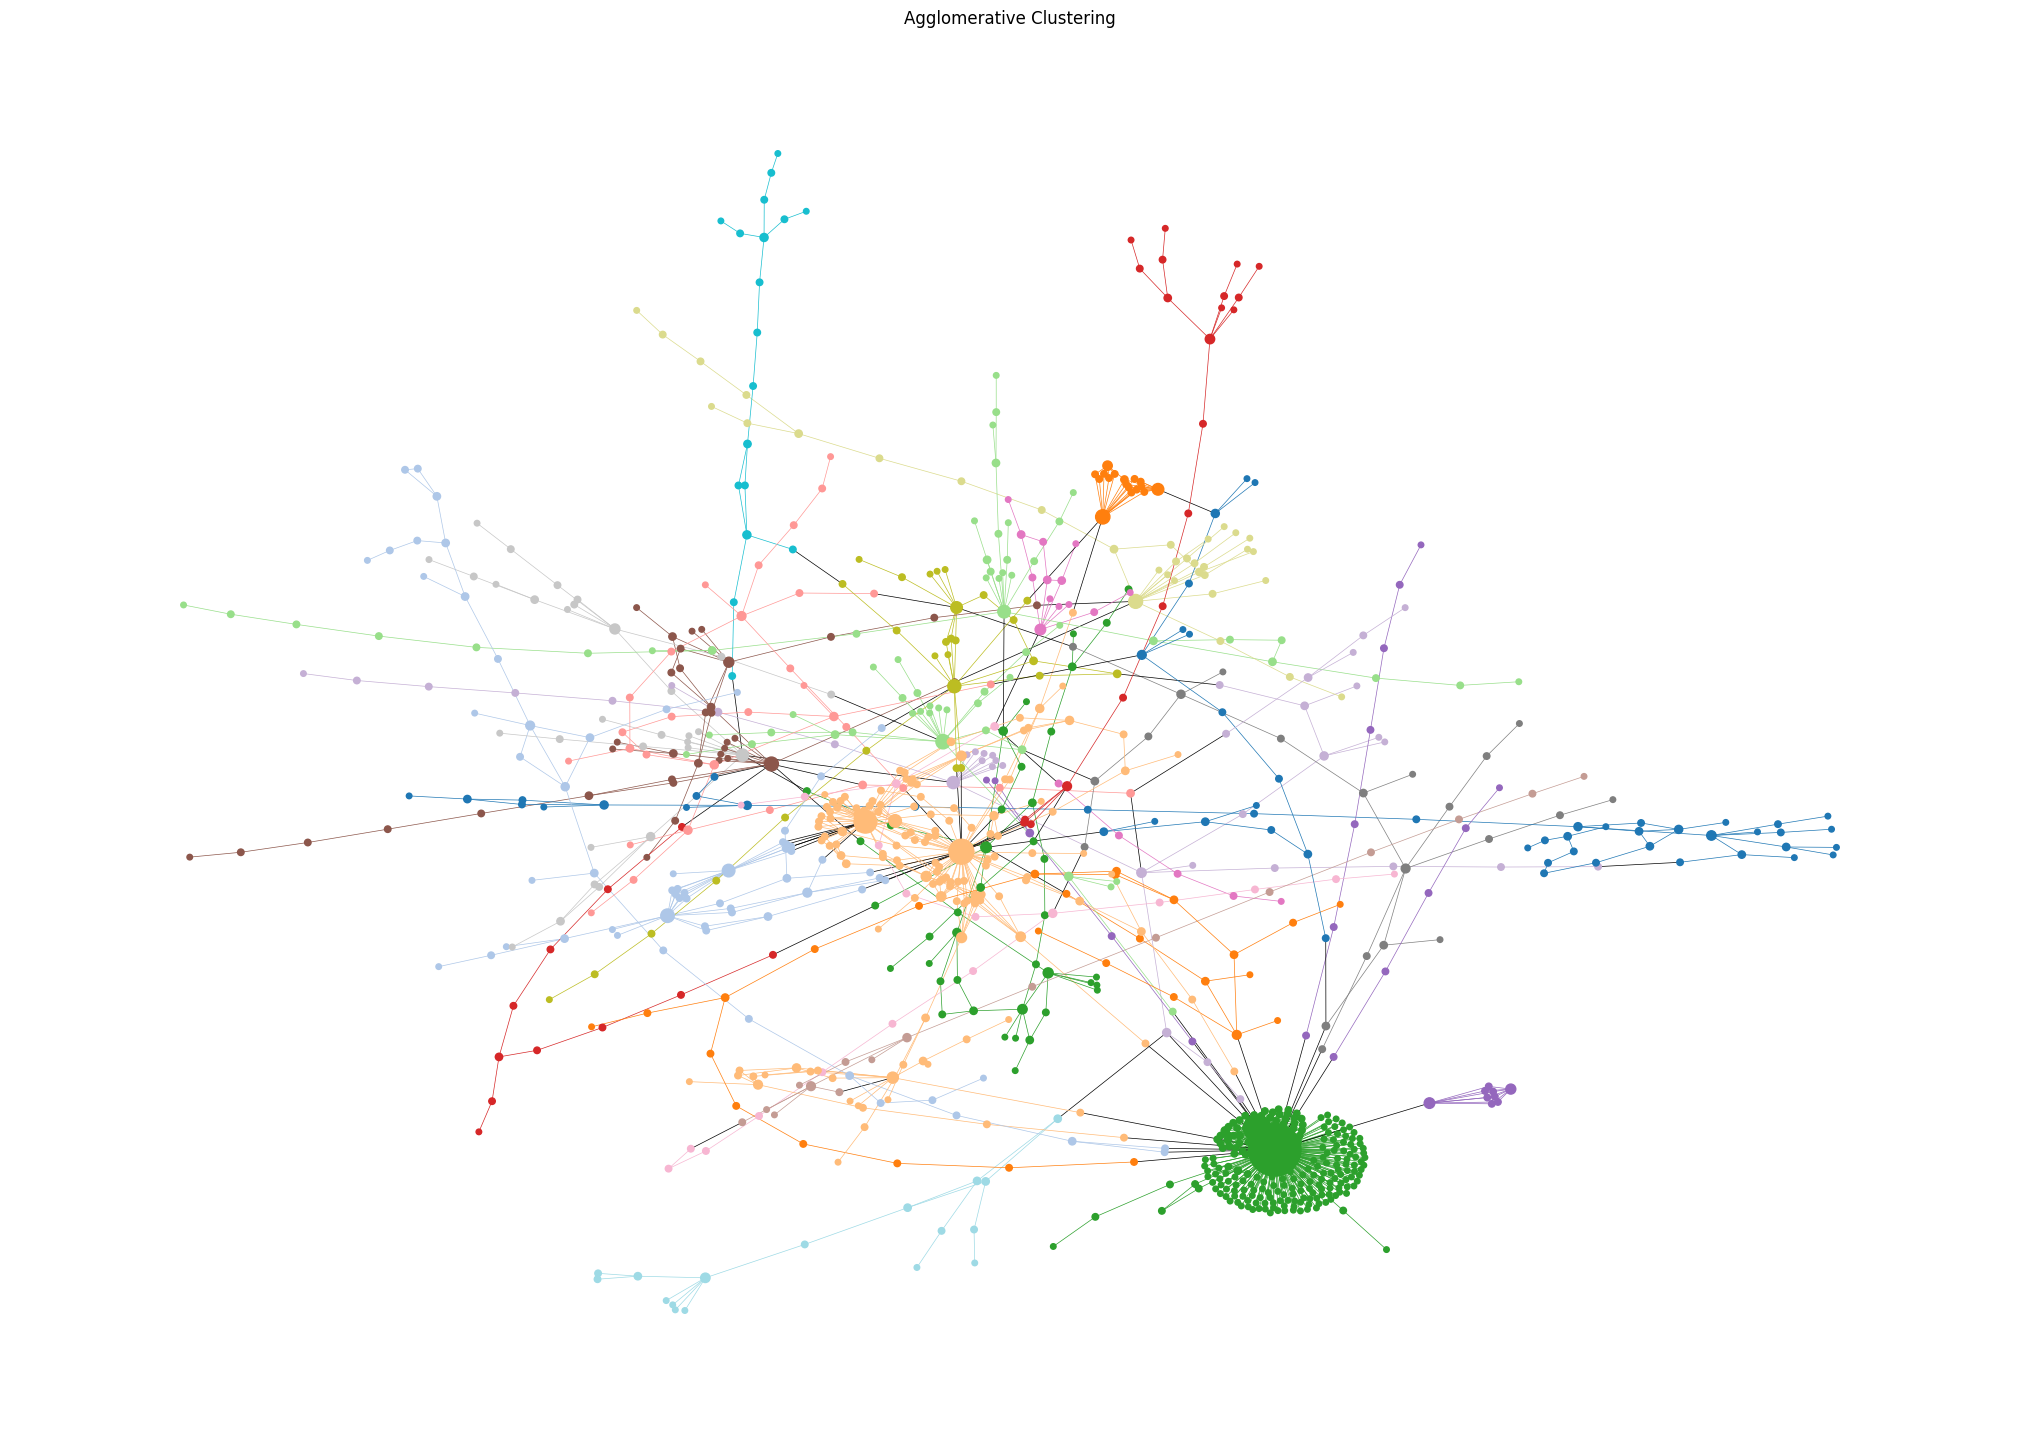

In [36]:
start = time.time()
n_clusters = 27

hclust = AgglomerativeClustering(n_clusters)
labels = hclust.fit_predict(node_vectors)

end_ac = time.time() - start

colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]
node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Agglomerative Clustering')
plt.show()

In [37]:
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_ac)

results.loc[len(results)] = ['Agglomerative Clustering',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_ac, 5)]

Модулярность: 0.8428764886850498
Коэффициент силуэта: 0.3365427
Индекс Калински-Харабаша: 84.61969466659257
Индекс Дэвиcа-Боулдина: 1.355494255197986
Время выполнения 0.015710830688476562


## 10) Spectral Clustering

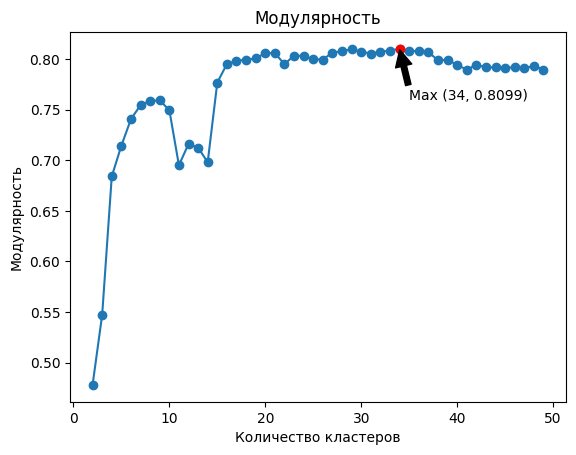

In [38]:
modularity_scores = []

for k in range(2, 50):
    kmeans = SpectralClustering(n_clusters=k,  affinity='nearest_neighbors')
    kmeans.fit(node_vectors)
    labels = kmeans.labels_
    partition = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(k)]
    modularity_scores.append(modularity(G, partition))

plt.plot(range(2, 50), modularity_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Модулярность')
plt.title('Модулярность')

# Находим индекс максимального значения модулярности
max_modularity_index = modularity_scores.index(max(modularity_scores))

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_scores[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_scores[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_scores[max_modularity_index]),
             xytext=(max_modularity_index + 3, modularity_scores[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.02))

plt.show()

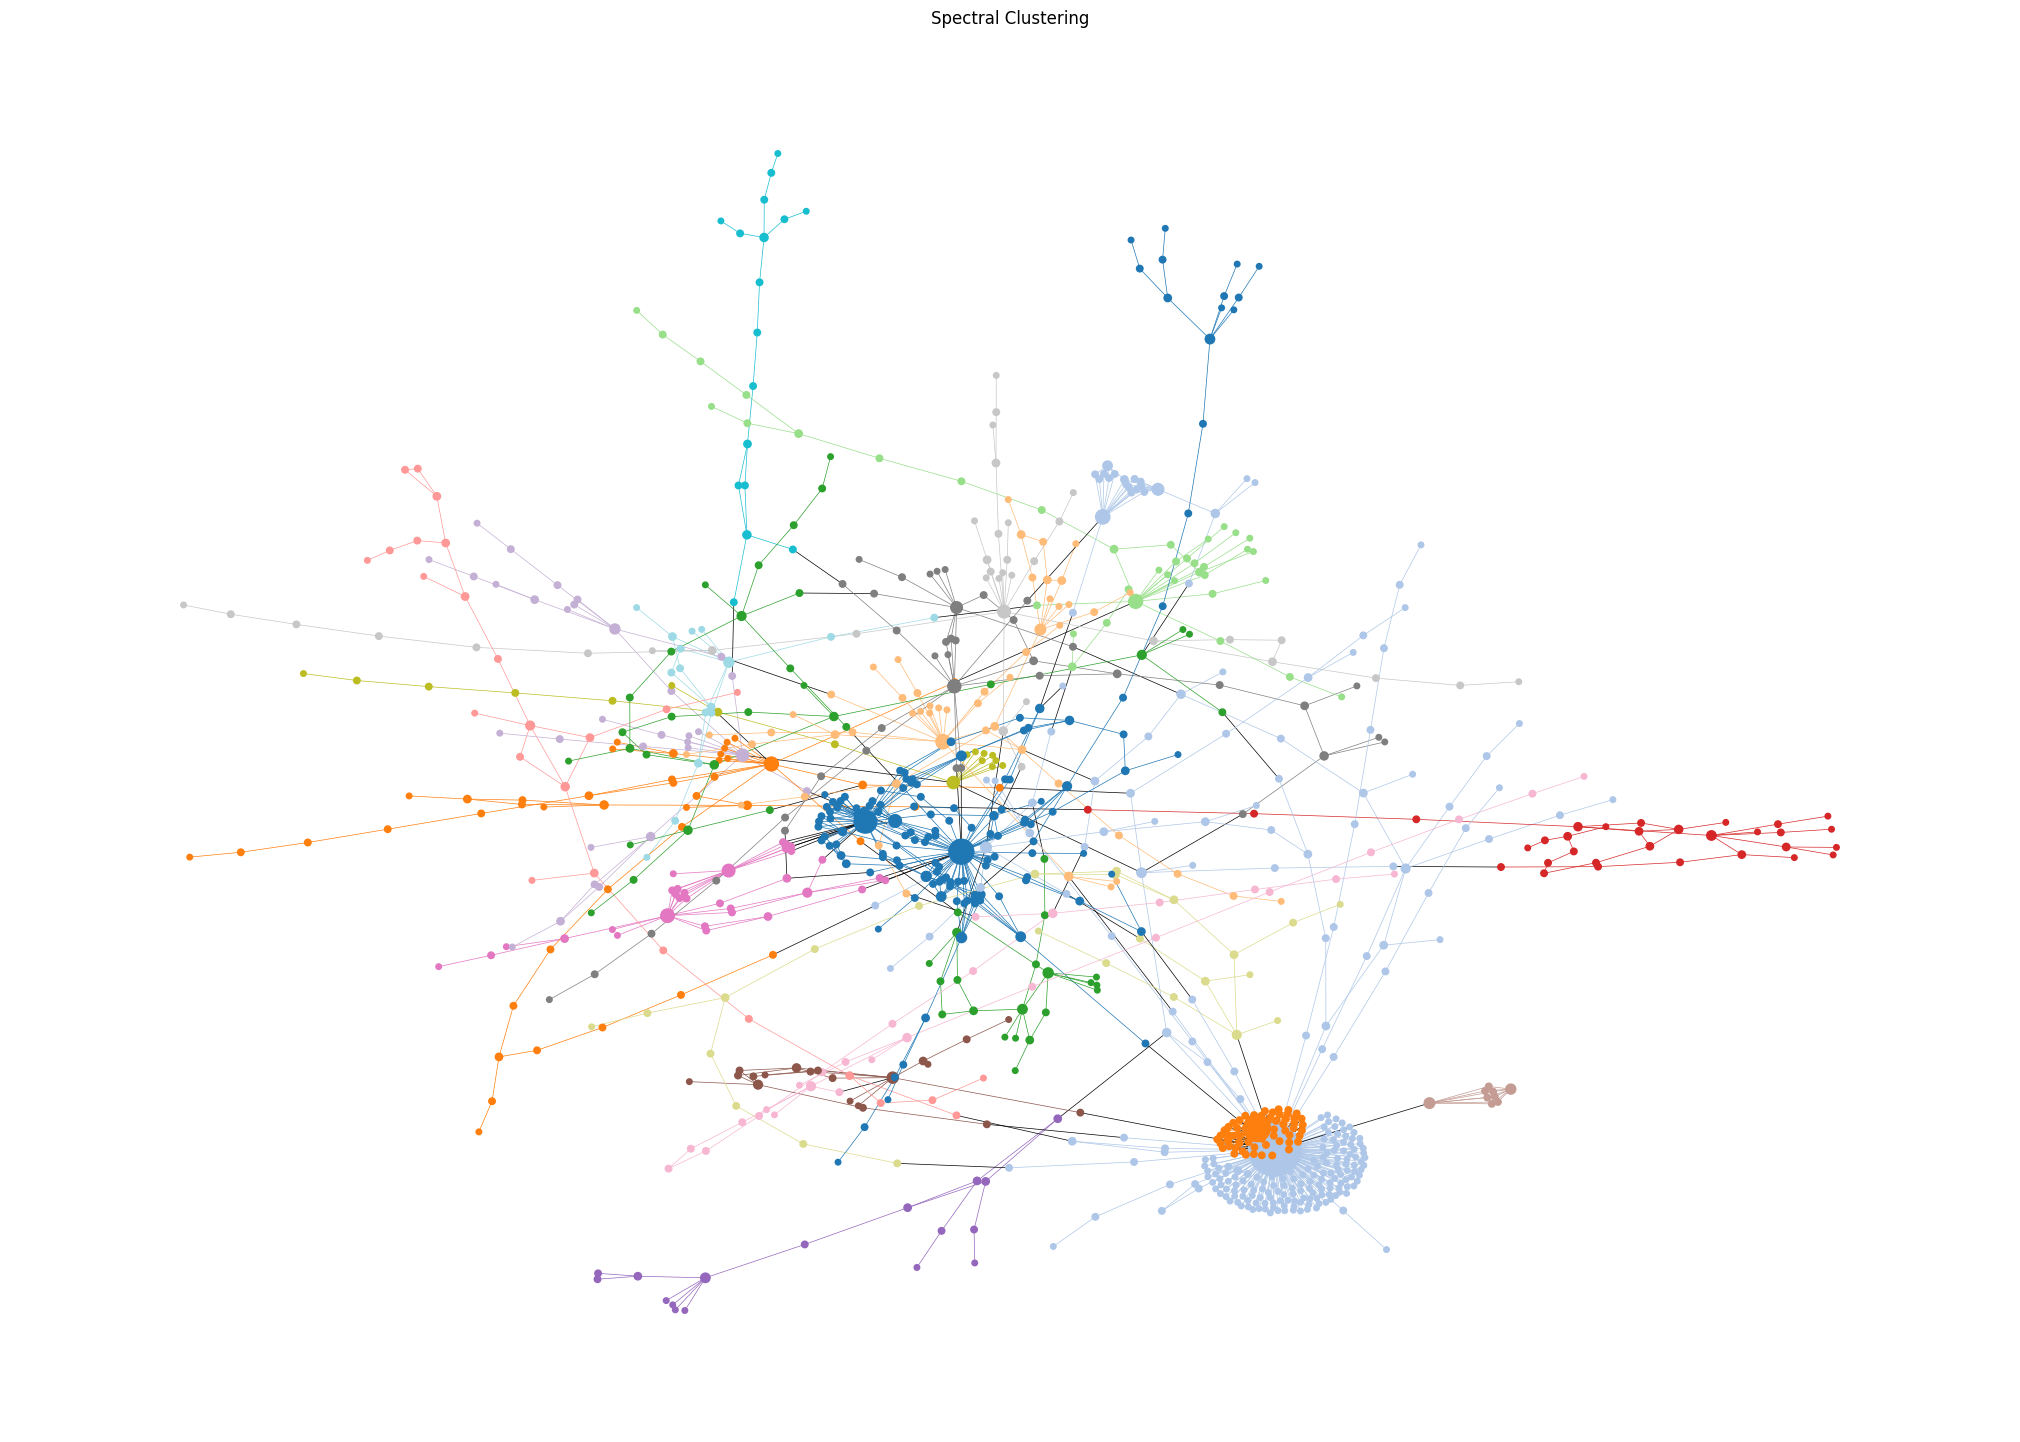

In [39]:
start = time.time()
n_clusters = 25

spectral_cluster = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
labels = spectral_cluster.fit_predict(node_vectors)
end_sc = time.time() - start

colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Spectral Clustering')
plt.show()

In [40]:
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_sc)

results.loc[len(results)] = ['Spectral Clustering',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_sc, 5)]

Модулярность: 0.7997450664768485
Коэффициент силуэта: 0.15914972
Индекс Калински-Харабаша: 78.93934109330439
Индекс Дэвиcа-Боулдина: 1.3474870777634402
Время выполнения 0.7335410118103027


## 11) Affinity Propagation

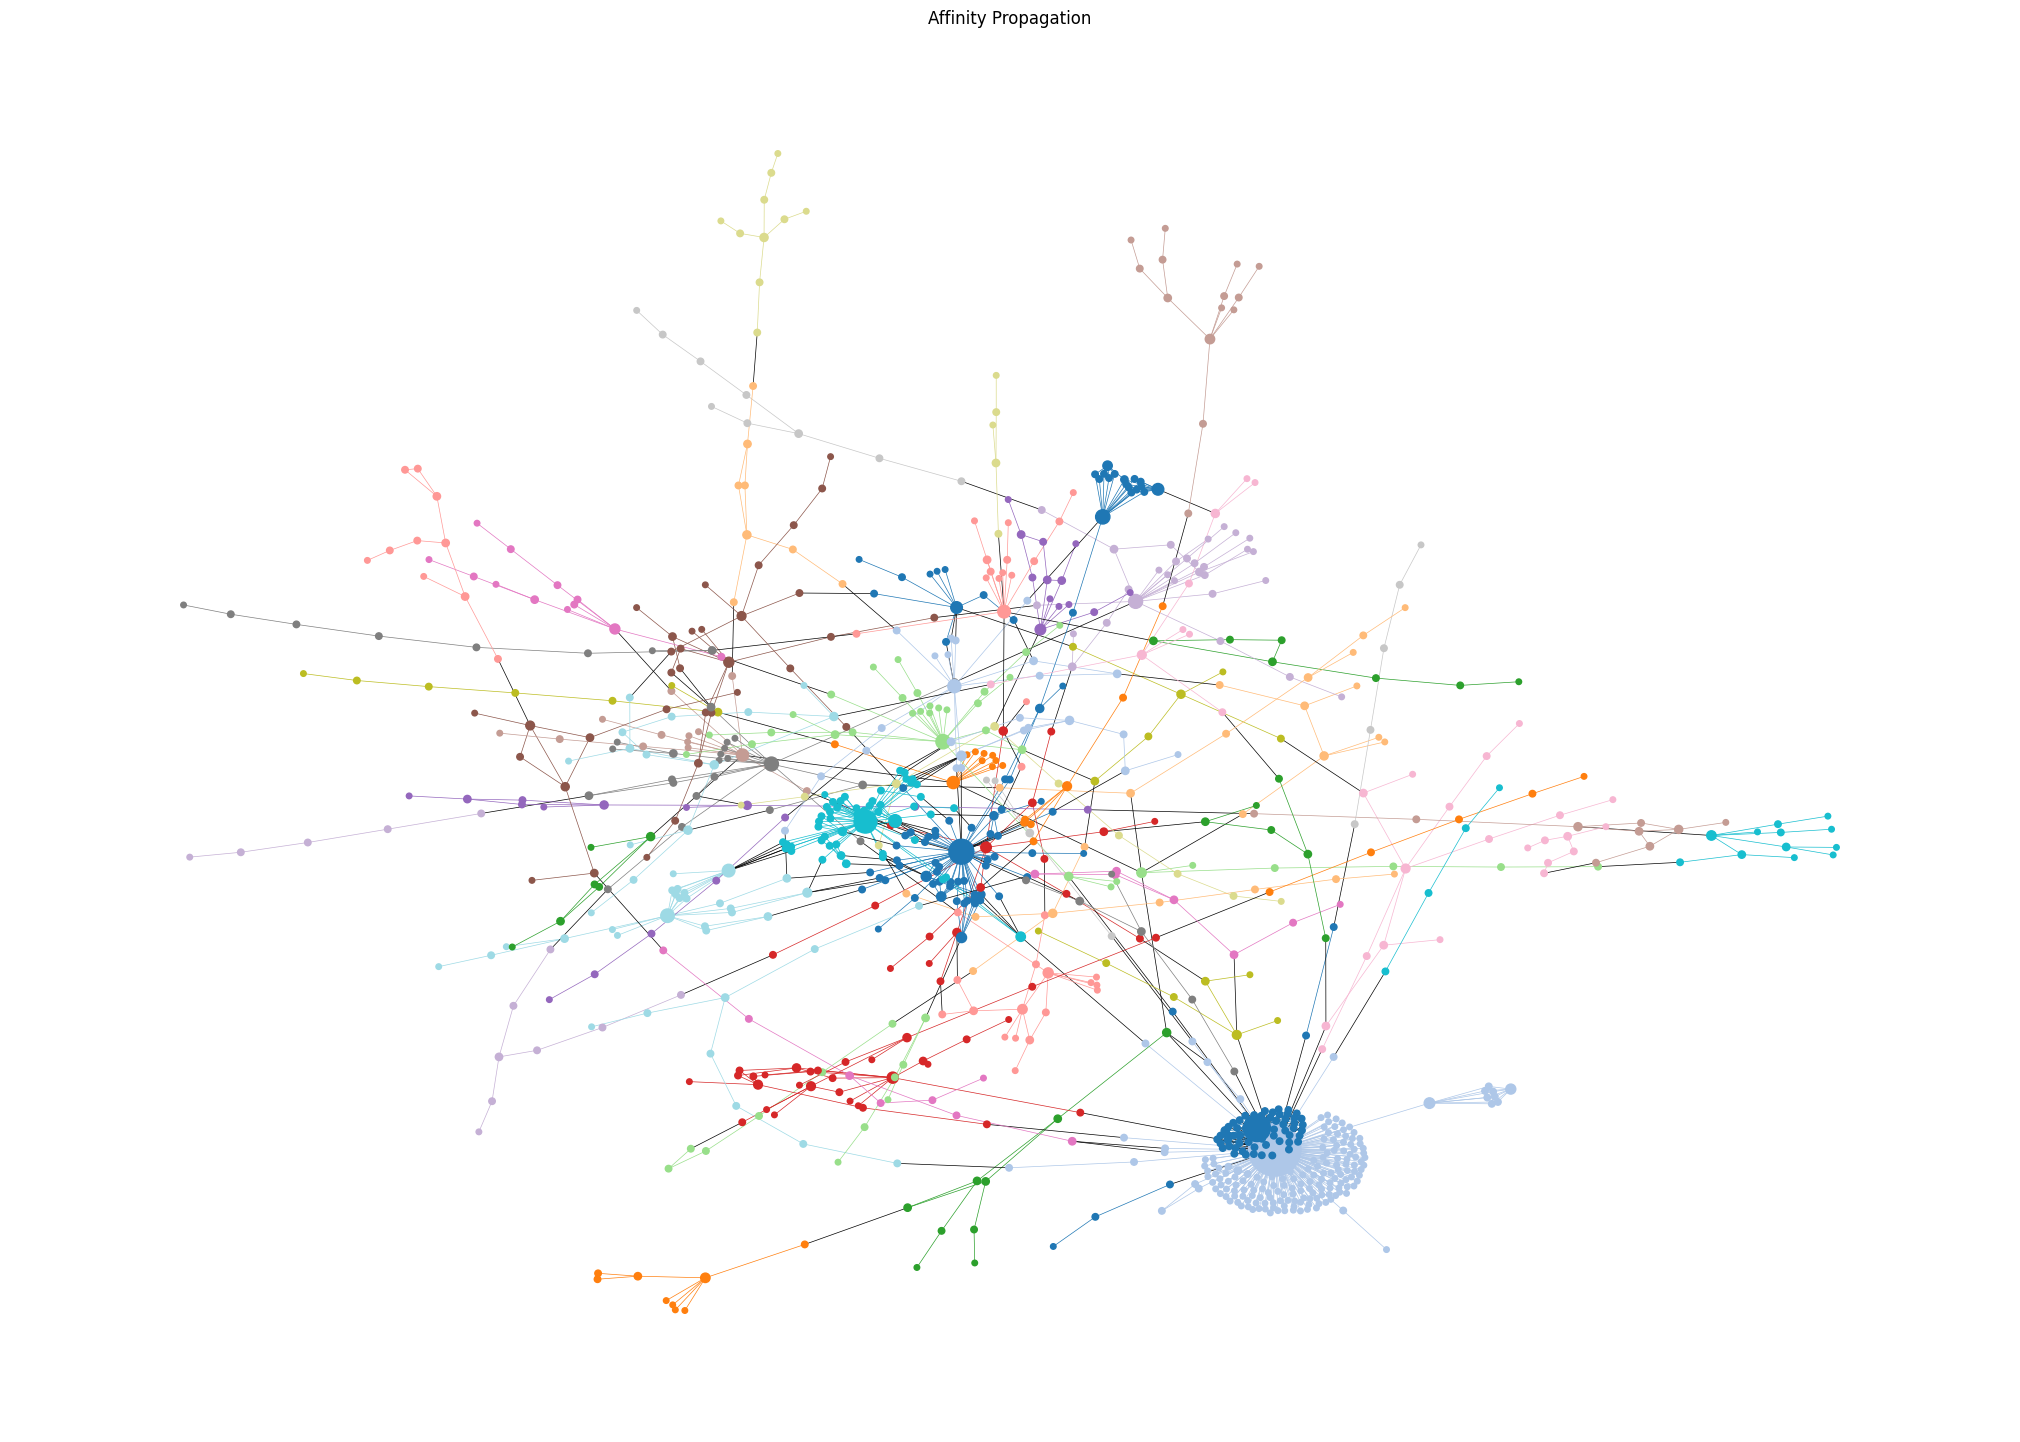

In [41]:
start = time.time()
affinity_cluster = AffinityPropagation()
labels = affinity_cluster.fit_predict(node_vectors)
end_ap = time.time() - start

colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Affinity Propagation')
plt.show()

In [42]:
n_clusters = len(affinity_cluster.cluster_centers_indices_)
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_ap)

results.loc[len(results)] = ['Affinity Propagation',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_ap, 5)]

Модулярность: 0.7815717844807366
Коэффициент силуэта: 0.2937062
Индекс Калински-Харабаша: 84.23908635554781
Индекс Дэвиcа-Боулдина: 1.0125873659302769
Время выполнения 0.3365790843963623


## 12) Mean Shift Clustering

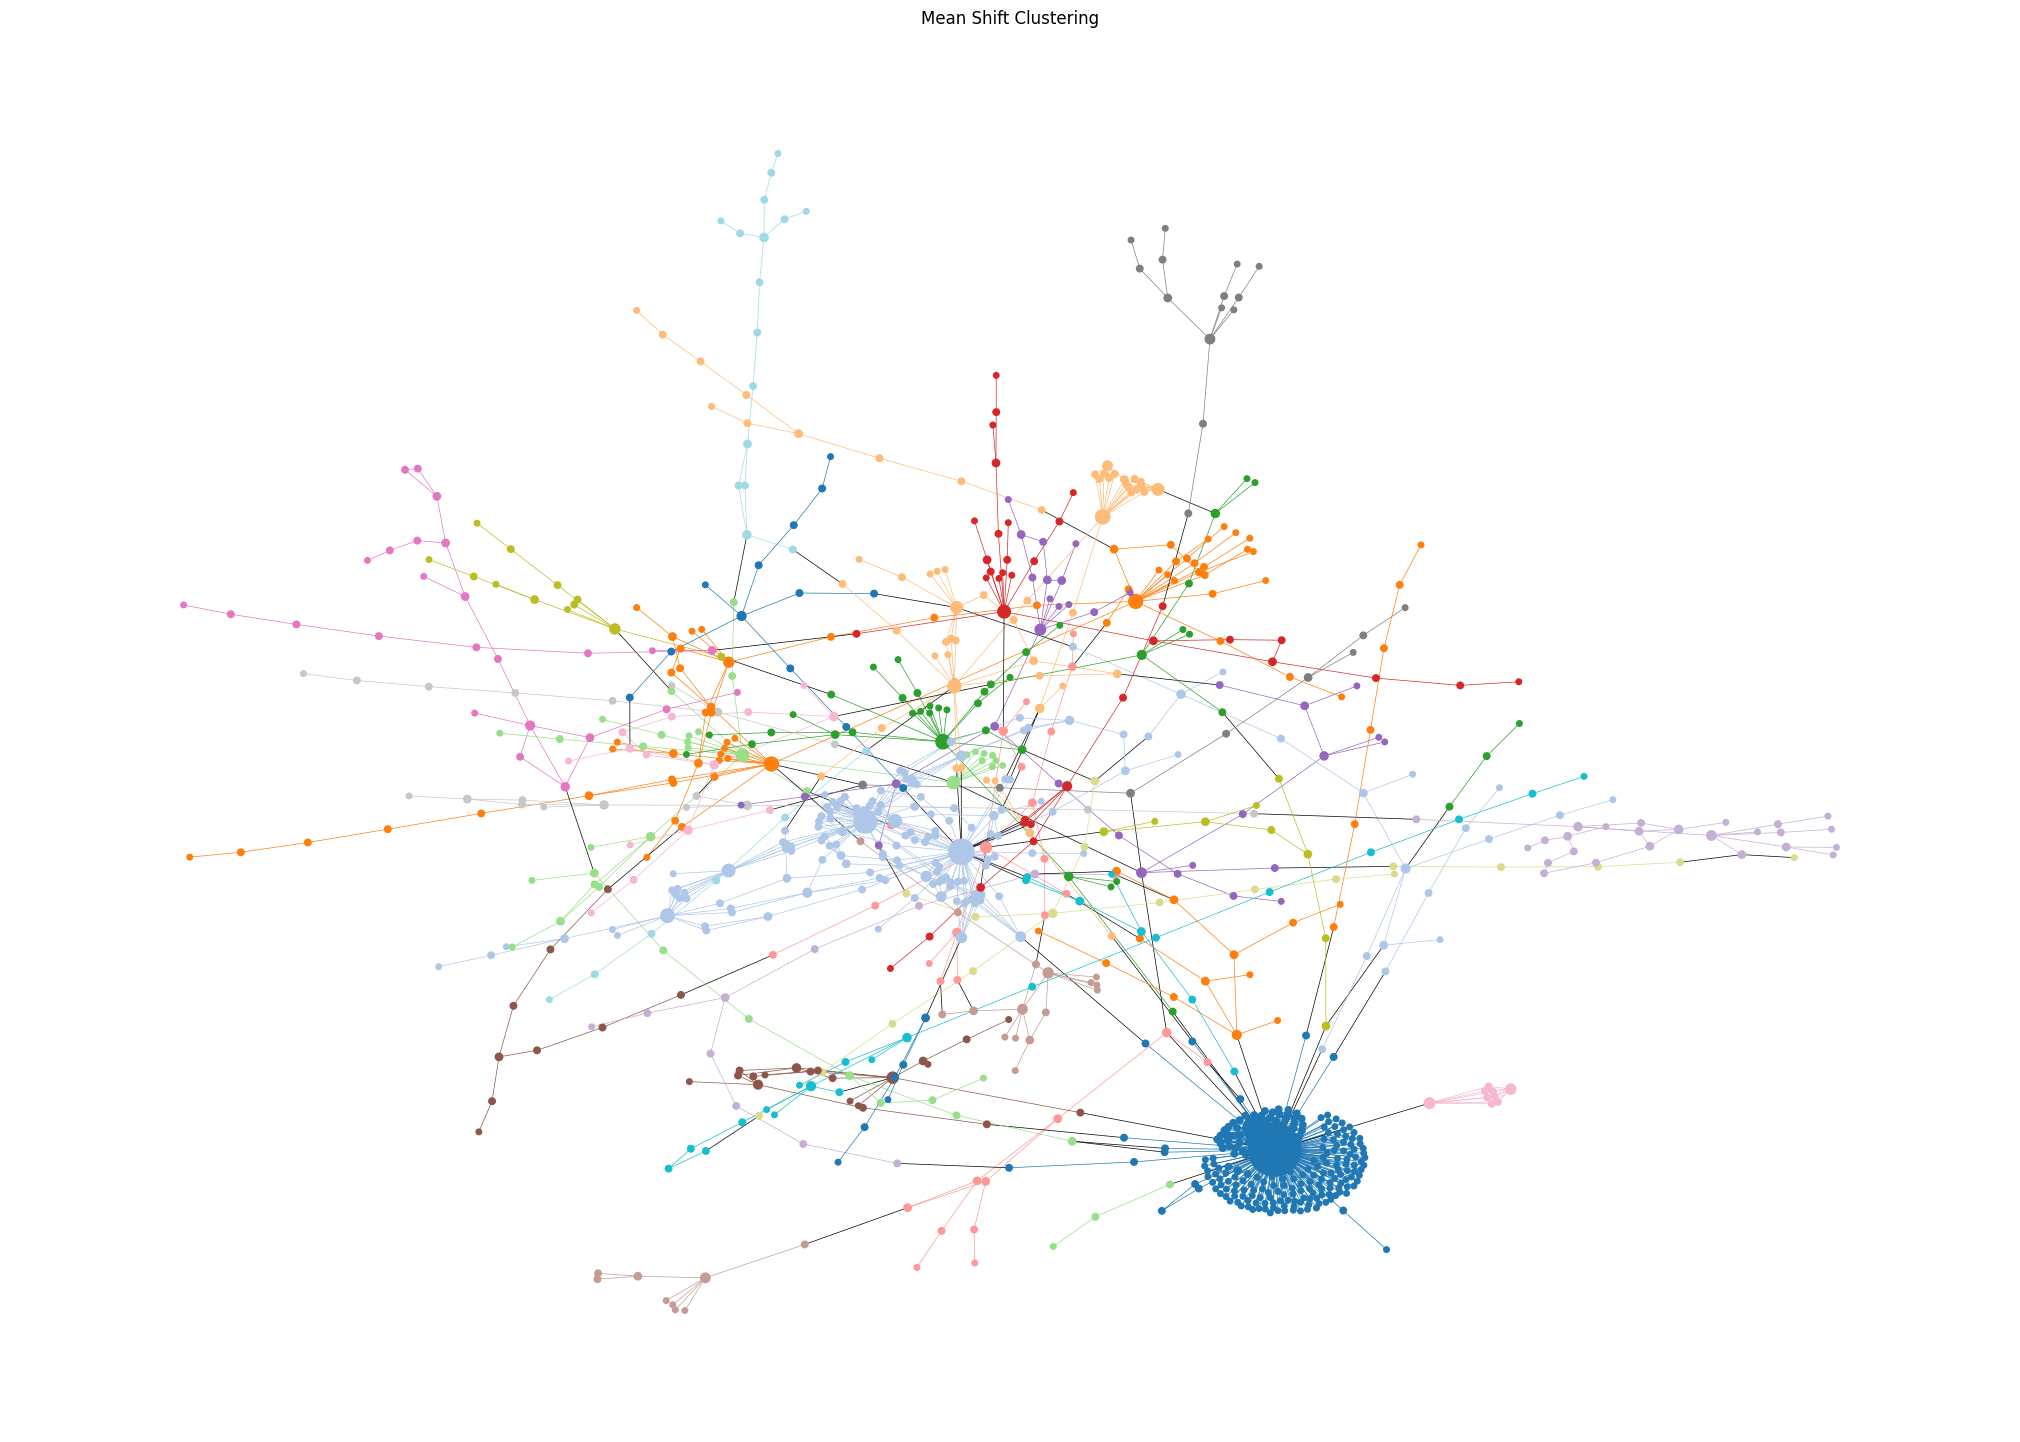

In [43]:
start = time.time()
meanshift = MeanShift(bandwidth=2)
labels = meanshift.fit_predict(node_vectors)
end_msc = time.time() - start

colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('Mean Shift Clustering')
plt.show()

In [44]:
n_clusters = len(np.unique(labels))
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_msc)

results.loc[len(results)] = ['Mean Shift Clustering',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_msc, 5)]

Модулярность: 0.8260237111094937
Коэффициент силуэта: 0.37939805
Индекс Калински-Харабаша: 74.57516128100556
Индекс Дэвиcа-Боулдина: 1.018878048351236
Время выполнения 3.0299158096313477


## 13) Birch

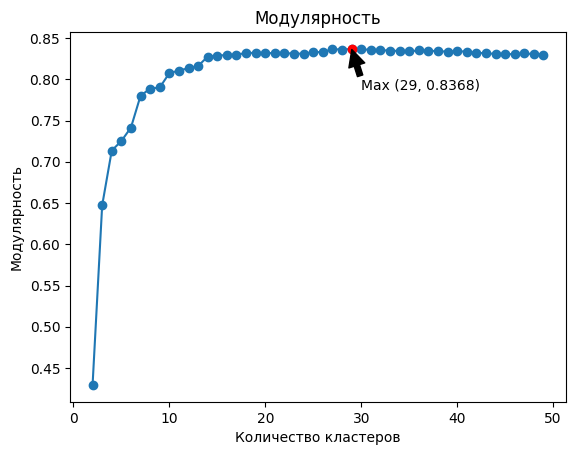

In [45]:
modularity_scores = []

for k in range(2, 50):
    kmeans = Birch(n_clusters=k)
    kmeans.fit(node_vectors)
    labels = kmeans.labels_
    partition = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(k)]
    modularity_scores.append(modularity(G, partition))

plt.plot(range(2, 50), modularity_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Модулярность')
plt.title('Модулярность')

# Находим индекс максимального значения модулярности
max_modularity_index = modularity_scores.index(max(modularity_scores))

# Добавляем красную точку для максимального значения модулярности
plt.plot(max_modularity_index + 2, modularity_scores[max_modularity_index], 'ro')

# Выводим номер шага
plt.annotate(f'Max ({max_modularity_index + 2}, {modularity_scores[max_modularity_index]:.4f})',
             xy=(max_modularity_index + 2, modularity_scores[max_modularity_index]),
             xytext=(max_modularity_index + 3, modularity_scores[max_modularity_index] - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.02))

plt.show()

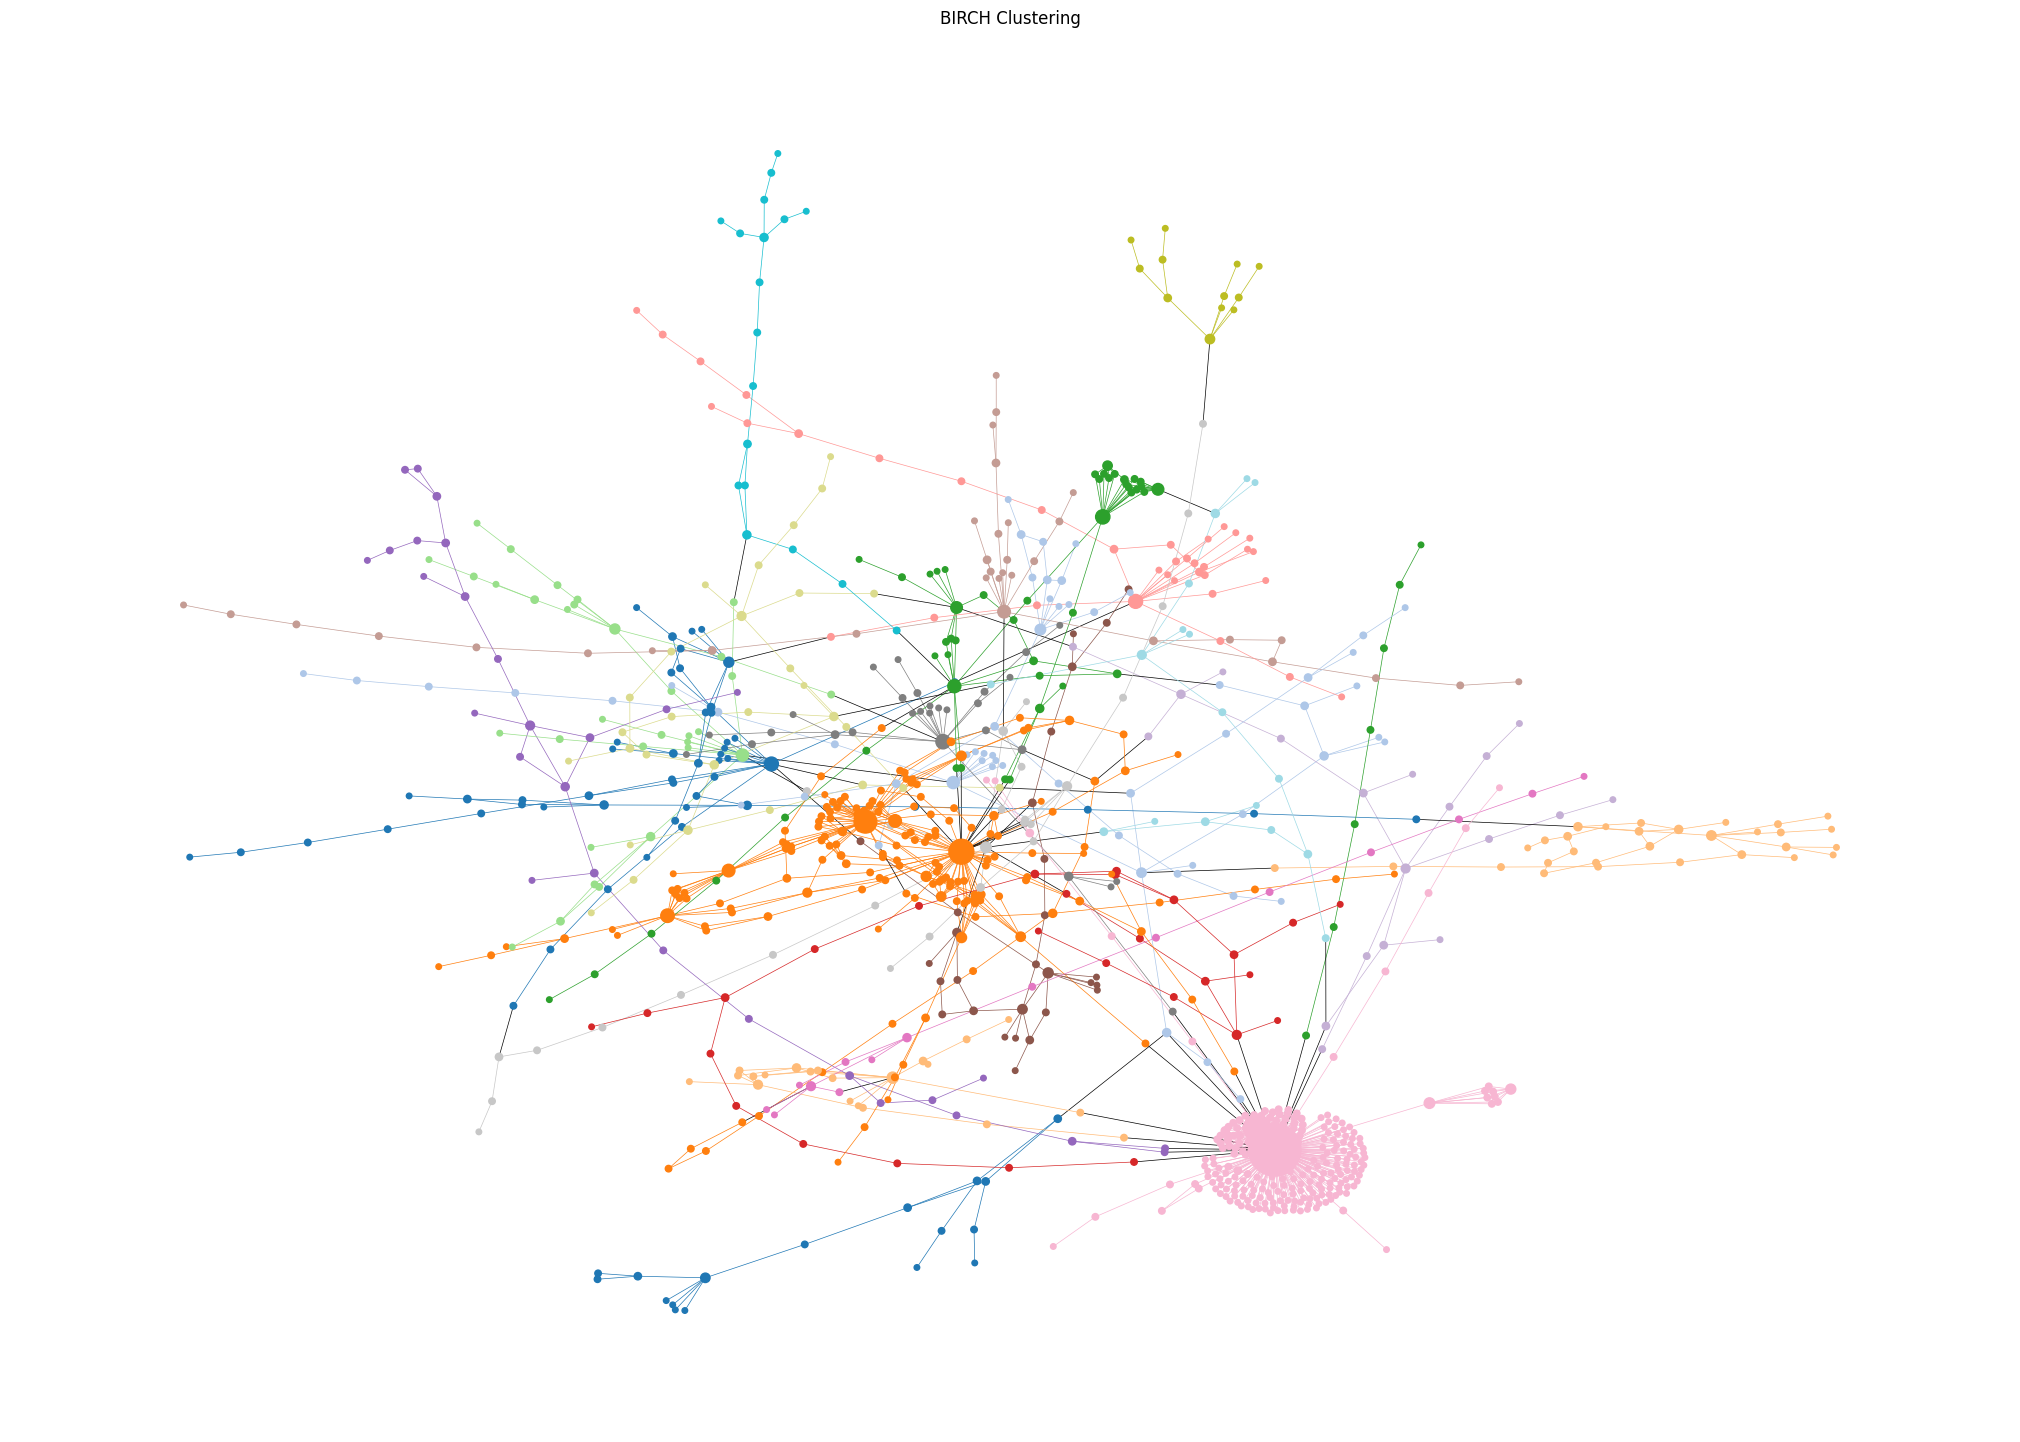

In [46]:
start = time.time()
birch = Birch(n_clusters=25)

# Применяем кластеризацию к векторам узлов
labels = birch.fit_predict(node_vectors)
end_birch = time.time() - start

# Создаем словарь цветов для узлов
colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

# Создаем цвета для ребер
edge_colors = ['black' if node_color_dict[u] != node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

# Создаем словарь степеней узлов
node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('BIRCH Clustering')
plt.show()

In [47]:
n_clusters = len(np.unique(labels))
communities = [{node for node, label in zip(G.nodes, labels) if label == i} for i in range(n_clusters)]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

# Вычисляем коэффициент силуэта
silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

# Вычисляем индекс Калински-Харабаша
CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

# Вычисляем индекс Дэвиcа-Боулдина
DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_birch)

results.loc[len(results)] = ['BIRCH',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_birch, 5)]

Модулярность: 0.8328729430733848
Коэффициент силуэта: 0.3527312
Индекс Калински-Харабаша: 84.45234170430138
Индекс Дэвиcа-Боулдина: 1.2729247175920289
Время выполнения 0.025719165802001953


## 14) OPTICS

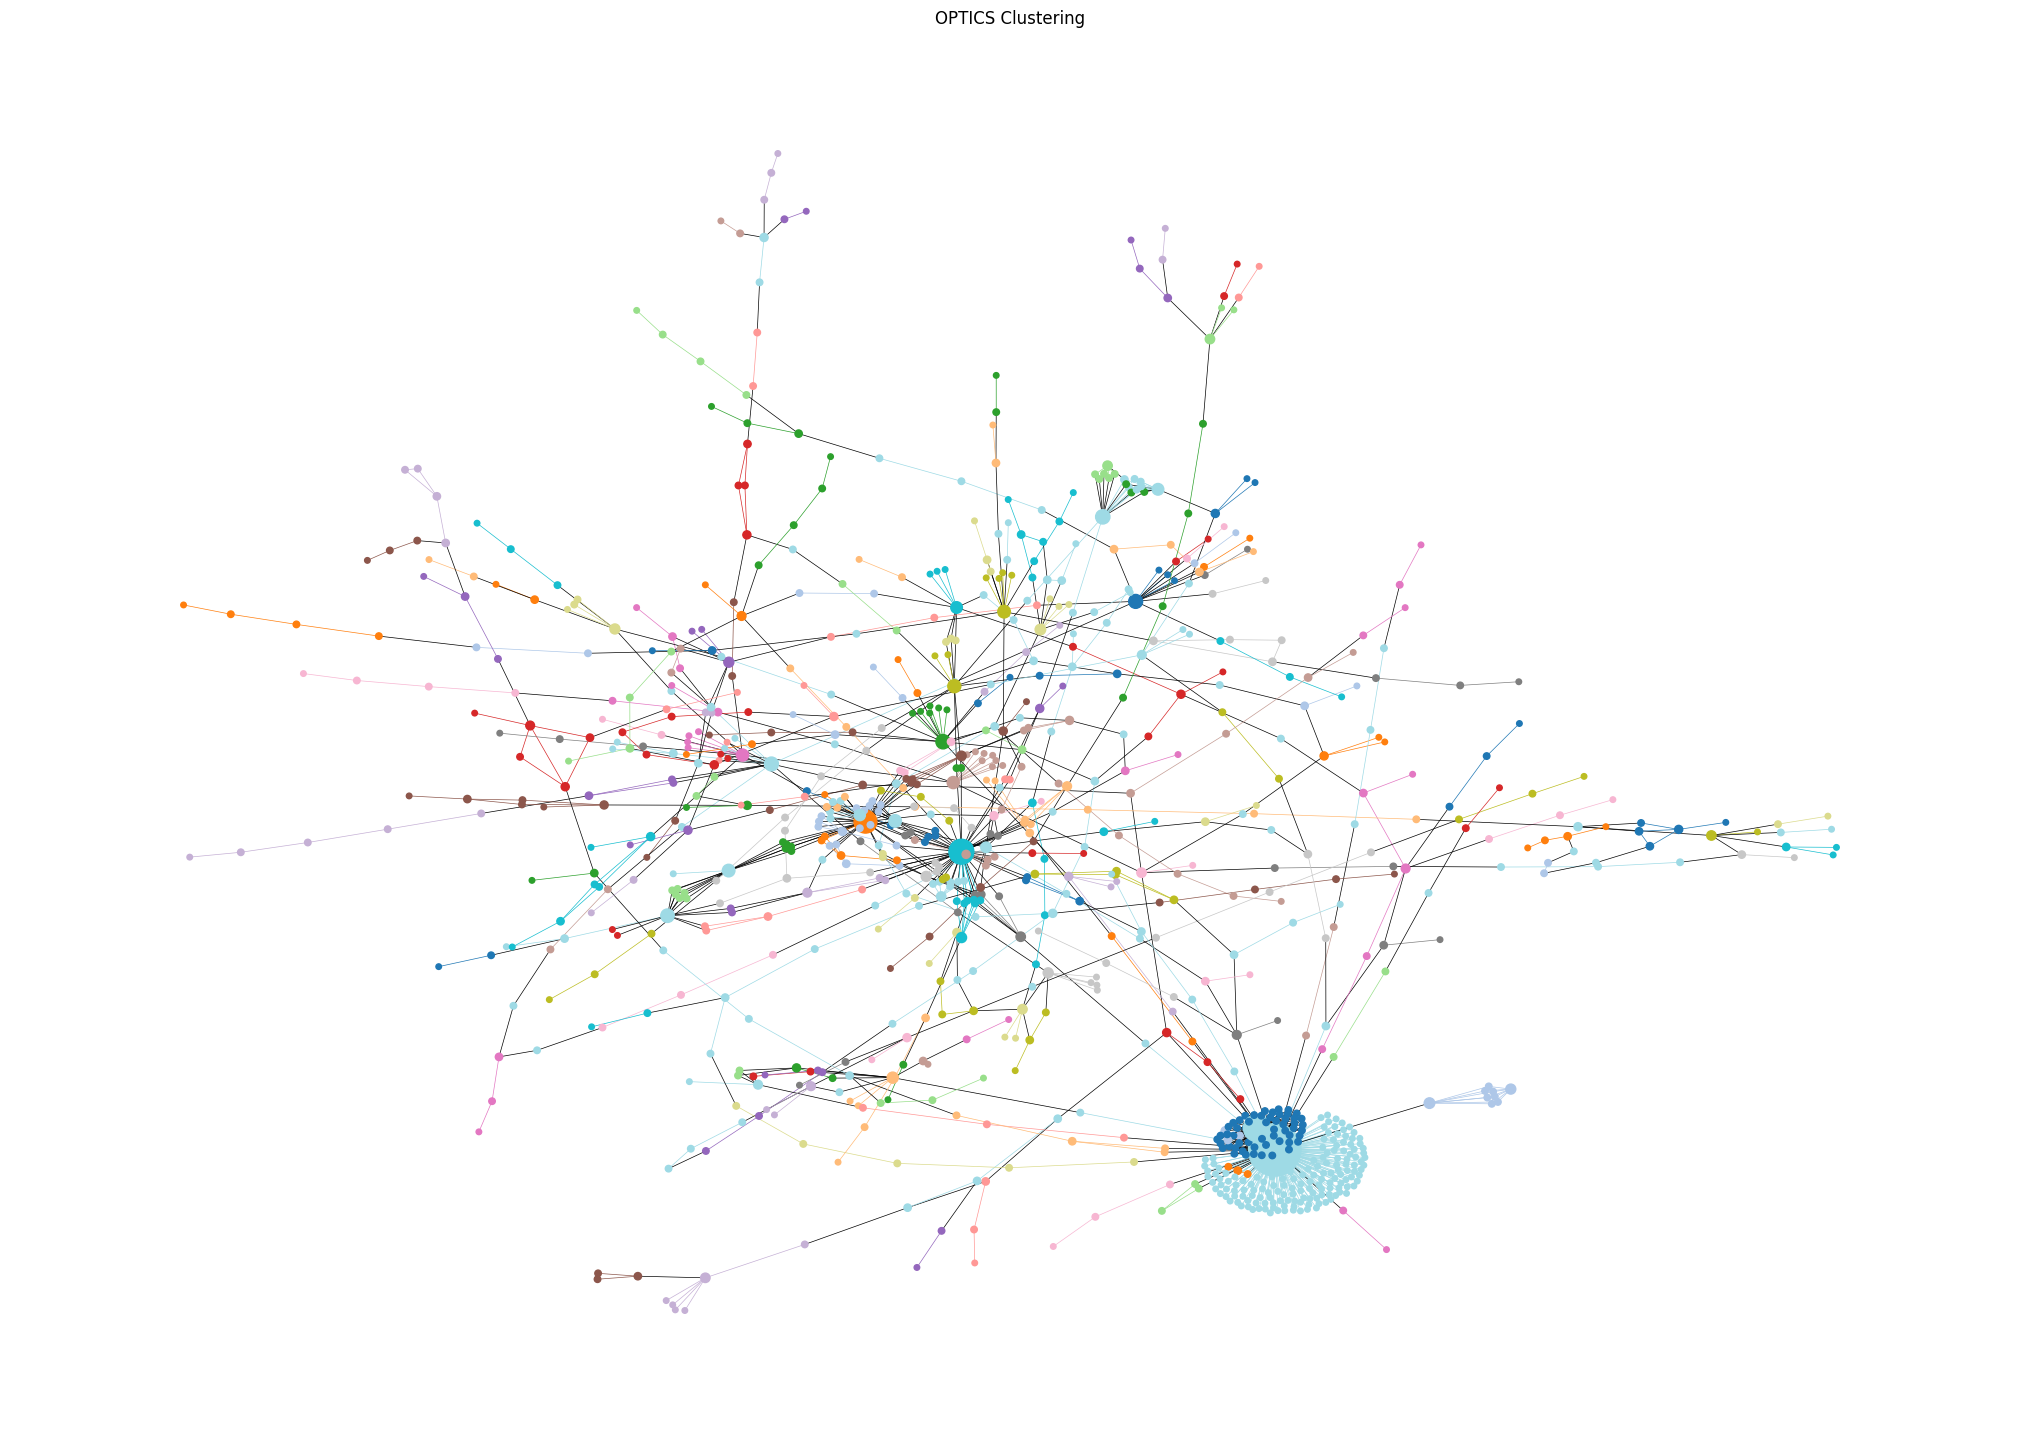

Количество кластеров: 227
Количество выбросов: 255


In [48]:
start = time.time()
optics = OPTICS(min_samples=2, max_eps=1.5)

labels = optics.fit_predict(node_vectors)
end_optics = time.time() - start

colors = plt.cm.tab20.colors
node_color_dict = {node: colors[label % len(
    colors)] for node, label in zip(G.nodes, labels)}
node_colors = [node_color_dict[node] for node in G.nodes]

edge_colors = ['black'if node_color_dict[u] !=
               node_color_dict[v] else node_color_dict[u] for u, v in G.edges]

node_degrees = dict(G.degree())
node_sizes = [10 + node_degrees[node] * 6 for node in G.nodes]

plt.figure(figsize=(20, 14))
nx.draw(G, pos=nx.spring_layout(G, seed=52), node_color=node_colors,
        edge_color=edge_colors, with_labels=False, node_size=node_sizes, width=0.5)
plt.title('OPTICS Clustering')
plt.show()

# Определяем количество кластеров и выбросов
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_outliers = list(labels).count(-1)

print("Количество кластеров:", n_clusters)
print("Количество выбросов:", n_outliers)

In [49]:
clusters = {}
for i, label in enumerate(labels):
    node_name = list(G.nodes)[i]
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(node_name)

communities = [set(cluster) for cluster in clusters.values()]

modularity_value = modularity(G, communities)
print("Модулярность:", modularity_value)

silhouette = silhouette_score(node_vectors, labels)
print("Коэффициент силуэта:", silhouette)

CH = calinski_harabasz_score(node_vectors, labels)
print("Индекс Калински-Харабаша:", CH)

DB = davies_bouldin_score(node_vectors, labels)
print("Индекс Дэвиcа-Боулдина:", DB)

print('Время выполнения', end_optics)

results.loc[len(results)] = ['OPTICS',
                             len(communities),
                             round(modularity_value, 5),
                             round(silhouette, 5),
                             round(CH, 5),
                             round(DB, 5),
                             round(end_optics, 5)]

Модулярность: 0.43693158991698217
Коэффициент силуэта: 0.16214536
Индекс Калински-Харабаша: 15.819335903592652
Индекс Дэвиcа-Боулдина: 0.8165767692354486
Время выполнения 0.6899697780609131


# Результаты

## По модулярности

In [50]:
results.sort_values(by='Модулярность', ascending=False)

Метод  Количество кластеров  Модулярность  \
0               Лувенский алгоритм                    30       0.84712   
1         Алгоритм Гирвана-Ньюмена                    28       0.84423   
2   Greedy Modularity Maximization                    31       0.84373   
8         Agglomerative Clustering                    27       0.84288   
12                           BIRCH                    25       0.83287   
11           Mean Shift Clustering                    46       0.82602   
6               K-Means Clustering                    22       0.82364   
5                Fluid Communities                    18       0.82197   
9              Spectral Clustering                    25       0.79975   
10            Affinity Propagation                    66       0.78157   
7                           DBSCAN                    27       0.76535   
4                  Synchronous LPA                   209       0.67478   
3                 Asynchronous LPA                   207       0.67062   
13                          OPTICS                   228       0.43693   

    Коэффициент силуэта  Индекс Калински-Харабаша  Индекс Дэвиcа-Боулдина  \
0               0.32667                  74.13636                 1.21128   
1               0.31293                  72.86608                 1.30906   
2               0.33505                  72.89910                 1.21717   
8               0.33654                  84.61969                 1.35549   
12              0.35273                  84.45234                 1.27292   
11              0.37940                  74.57516                 1.01888   
6               0.34309                  91.48454                 1.31126   
5               0.26280                  72.68281                 1.67034   
9               0.15915                  78.93934                 1.34749   
10              0.29371                  84.23909                 1.01259   
7               0.17408                  36.25112                 1.63664   
4               0.33660                  53.63043                 0.84316   
3               0.32682                  55.80550                 0.87966   
13              0.16215                  15.81934                 0.81658   

    Время выполнения  
0            0.03254  
1           35.15133  
2            0.26823  
8            0.01571  
12           0.02572  
11           3.02992  
6            0.20883  
5            0.05768  
9            0.73354  
10           0.33658  
7            0.02714  
4            0.06118  
3            0.03885  
13           0.68997

## По коэффициенту силуэта

In [51]:
results.sort_values(by='Коэффициент силуэта', ascending=False)

Метод  Количество кластеров  Модулярность  \
11           Mean Shift Clustering                    46       0.82602   
12                           BIRCH                    25       0.83287   
6               K-Means Clustering                    22       0.82364   
4                  Synchronous LPA                   209       0.67478   
8         Agglomerative Clustering                    27       0.84288   
2   Greedy Modularity Maximization                    31       0.84373   
3                 Asynchronous LPA                   207       0.67062   
0               Лувенский алгоритм                    30       0.84712   
1         Алгоритм Гирвана-Ньюмена                    28       0.84423   
10            Affinity Propagation                    66       0.78157   
5                Fluid Communities                    18       0.82197   
7                           DBSCAN                    27       0.76535   
13                          OPTICS                   228       0.43693   
9              Spectral Clustering                    25       0.79975   

    Коэффициент силуэта  Индекс Калински-Харабаша  Индекс Дэвиcа-Боулдина  \
11              0.37940                  74.57516                 1.01888   
12              0.35273                  84.45234                 1.27292   
6               0.34309                  91.48454                 1.31126   
4               0.33660                  53.63043                 0.84316   
8               0.33654                  84.61969                 1.35549   
2               0.33505                  72.89910                 1.21717   
3               0.32682                  55.80550                 0.87966   
0               0.32667                  74.13636                 1.21128   
1               0.31293                  72.86608                 1.30906   
10              0.29371                  84.23909                 1.01259   
5               0.26280                  72.68281                 1.67034   
7               0.17408                  36.25112                 1.63664   
13              0.16215                  15.81934                 0.81658   
9               0.15915                  78.93934                 1.34749   

    Время выполнения  
11           3.02992  
12           0.02572  
6            0.20883  
4            0.06118  
8            0.01571  
2            0.26823  
3            0.03885  
0            0.03254  
1           35.15133  
10           0.33658  
5            0.05768  
7            0.02714  
13           0.68997  
9            0.73354

## По индексу Калински-Харабаша

In [52]:
results.sort_values(by='Индекс Калински-Харабаша', ascending=False)

Метод  Количество кластеров  Модулярность  \
6               K-Means Clustering                    22       0.82364   
8         Agglomerative Clustering                    27       0.84288   
12                           BIRCH                    25       0.83287   
10            Affinity Propagation                    66       0.78157   
9              Spectral Clustering                    25       0.79975   
11           Mean Shift Clustering                    46       0.82602   
0               Лувенский алгоритм                    30       0.84712   
2   Greedy Modularity Maximization                    31       0.84373   
1         Алгоритм Гирвана-Ньюмена                    28       0.84423   
5                Fluid Communities                    18       0.82197   
3                 Asynchronous LPA                   207       0.67062   
4                  Synchronous LPA                   209       0.67478   
7                           DBSCAN                    27       0.76535   
13                          OPTICS                   228       0.43693   

    Коэффициент силуэта  Индекс Калински-Харабаша  Индекс Дэвиcа-Боулдина  \
6               0.34309                  91.48454                 1.31126   
8               0.33654                  84.61969                 1.35549   
12              0.35273                  84.45234                 1.27292   
10              0.29371                  84.23909                 1.01259   
9               0.15915                  78.93934                 1.34749   
11              0.37940                  74.57516                 1.01888   
0               0.32667                  74.13636                 1.21128   
2               0.33505                  72.89910                 1.21717   
1               0.31293                  72.86608                 1.30906   
5               0.26280                  72.68281                 1.67034   
3               0.32682                  55.80550                 0.87966   
4               0.33660                  53.63043                 0.84316   
7               0.17408                  36.25112                 1.63664   
13              0.16215                  15.81934                 0.81658   

    Время выполнения  
6            0.20883  
8            0.01571  
12           0.02572  
10           0.33658  
9            0.73354  
11           3.02992  
0            0.03254  
2            0.26823  
1           35.15133  
5            0.05768  
3            0.03885  
4            0.06118  
7            0.02714  
13           0.68997

## По индексу Дэвиcа-Боулдина

In [53]:
results.sort_values(by='Индекс Дэвиcа-Боулдина', ascending=False)

Метод  Количество кластеров  Модулярность  \
5                Fluid Communities                    18       0.82197   
7                           DBSCAN                    27       0.76535   
8         Agglomerative Clustering                    27       0.84288   
9              Spectral Clustering                    25       0.79975   
6               K-Means Clustering                    22       0.82364   
1         Алгоритм Гирвана-Ньюмена                    28       0.84423   
12                           BIRCH                    25       0.83287   
2   Greedy Modularity Maximization                    31       0.84373   
0               Лувенский алгоритм                    30       0.84712   
11           Mean Shift Clustering                    46       0.82602   
10            Affinity Propagation                    66       0.78157   
3                 Asynchronous LPA                   207       0.67062   
4                  Synchronous LPA                   209       0.67478   
13                          OPTICS                   228       0.43693   

    Коэффициент силуэта  Индекс Калински-Харабаша  Индекс Дэвиcа-Боулдина  \
5               0.26280                  72.68281                 1.67034   
7               0.17408                  36.25112                 1.63664   
8               0.33654                  84.61969                 1.35549   
9               0.15915                  78.93934                 1.34749   
6               0.34309                  91.48454                 1.31126   
1               0.31293                  72.86608                 1.30906   
12              0.35273                  84.45234                 1.27292   
2               0.33505                  72.89910                 1.21717   
0               0.32667                  74.13636                 1.21128   
11              0.37940                  74.57516                 1.01888   
10              0.29371                  84.23909                 1.01259   
3               0.32682                  55.80550                 0.87966   
4               0.33660                  53.63043                 0.84316   
13              0.16215                  15.81934                 0.81658   

    Время выполнения  
5            0.05768  
7            0.02714  
8            0.01571  
9            0.73354  
6            0.20883  
1           35.15133  
12           0.02572  
2            0.26823  
0            0.03254  
11           3.02992  
10           0.33658  
3            0.03885  
4            0.06118  
13           0.68997

## Вывод

Можно сделать следующие выводы:

1. Модульность (Modularity):
   - Лувенский алгоритм и алгоритм Гирвана-Ньюмана показывают наивысшую модулярность (>0.84), что указывает на хорошую способность этих методов выявлять четкие кластеры.
   - Алгоритмы LPA (Asynchronous и Synchronous), OPTICS и K-Means имеют значительно более низкую модулярность, что указывает на меньшую способность этих методов выявлять четкие сообщества в графе.

2. Коэффициент силуэта (Silhouette Coefficient):
   - Самые высокие значения коэффициента силуэта у Mean Shift Clustering (0.37767) и K-Means Clustering (0.35757), что свидетельствует о хорошем качестве кластеризации по мере схожести внутри кластеров и различия между ними.
   - Наихудшие значения у Asynchronous LPA (0.23431) и OPTICS (0.06041), что указывает на нечеткие границы кластеров.

3. Индекс Калински-Харабаша (Calinski-Harabasz Index):
   - Agglomerative Clustering (86.52268) и Spectral Clustering (80.65723) показывают наивысшие значения индекса Калински-Харабаша, что свидетельствует о хорошей плотности и отделении кластеров.
   - Наихудшие результаты у OPTICS (12.85441) и Asynchronous LPA (56.98121), что указывает на менее четкие кластеры.

4. Индекс Дэвиса-Боулдина (Davies-Bouldin Index):
   - Низкие значения этого индекса указывают на лучшее качество кластеров. Здесь лучшими являются Synchronous LPA (0.84763) и Asynchronous LPA (0.90059).
   - Наихудшие результаты у Fluid Communities (1.66445) и DBSCAN (1.67438), что указывает на меньшую четкость кластеров.

5. Время выполнения:
   - DBSCAN (0.01639 с) и Лувенский алгоритм (0.04641 и 0.04979 с) работают наиболее быстро.
   - Алгоритм Гирвана-Ньюмана (36.43464 с) и Spectral Clustering (1.42464 с) требуют значительно больше времени на выполнение.

Заключение:
- Если важна высокая модульность и скорость выполнения, Лувенский алгоритм является оптимальным выбором.
- Для лучшего коэффициента силуэта и баланса между качеством и временем выполнения, K-Means Clustering и Mean Shift Clustering являются хорошими вариантами.
- Если важен высокий индекс Калински-Харабаша, стоит рассмотреть Agglomerative и Spectral Clustering.
- В случае низкого индекса Дэвиса-Боулдина и приемлемого времени выполнения, LPA методы (особенно Synchronous) могут быть полезны.